<a href="https://colab.research.google.com/github/ShivinM-17/Cloud-fog-edge-task-scheduling/blob/main/Cloud_Task_Scheduling_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reliable Cloud-Fog-Edge Task Scheduling Using DQN Reinforcement Learning with PPO and Actor-Critic Neural Network Policies

## Creating the overall simulation environment for the task scheduling

This simulation will consist of 6 main components that will perform all of the necessary tasks as required and programmed. These are:

* Task
* Layer
* Management Node
* PPO Agent
* Task Scheduler
* Task Generator

In the end, a runtime function incorporates the all these components for a overall runtime simulation of the cloud-fog-edge environment and facilitate the task scheduling process.


### Import the necessary packages and modules

In [ ]:
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
import math
from contextlib import redirect_stdout

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Dense, MaxPool1D,Input, BatchNormalization, Dropout, LSTM, Flatten, SimpleRNN, MaxPooling1D, Reshape
from tensorflow.keras.optimizers import AdamW, Adam
from tensorflow.keras.regularizers import l2

### Creating the `TASK` class

This incorporated the tasks that will be assigned to the nodes of the cloud, fog, edge layers accordingly.

The tasks are their own internal parameters, which will allow for a more informative allocation and scheduling. These are:
* **Task id**: This is unique for each task
* **Complexity**: This tells how much computationally complex the task is. The more computationally expensive the task is, the more higher level of layer it will be assigned to.
* **Required Completion time**: This is the required time for a task to complete, after it has been fully allocated
* **Assigned Nodes**: This refers to the nodes of the layers that the task has been allocated to.

Other parameters are also present which monitor the task's migrations between layer, and the completion status of the task as well.

In [ ]:
class Task:
  def __init__(self, task_id, complexity, required_resources, required_completion_time):
    # Assigning the main task data
    self.id = task_id
    self.complexity = complexity
    self.resource_requirement = required_resources
    self.has_required_resources = False
    self.required_completion_time = required_completion_time
    self.assigned_node = []

    # Creating a list, for the layers task is allocated to
    self.alloted_layers = []

    # Get count of migrations for the task
    self.migrations = 0
    self.migrate_to = None

    # Check if the task is completed or not
    self.is_completed = False

    # Initialize the start and end time of the task
    self.time_processed = 0

    # Original status
    self.original_status = {
        'resource_requirement': self.resource_requirement,
        'migrations': self.migrations,
        'is_completed': self.is_completed
    }

  # Function to check whether task has been completed or not
  def check_completion(self) -> None:
    """
    This will check whether the task has been completed or not
    """
    # Check if the task has been stopped or not
    if self.time_processed >= self.required_completion_time:
      self.is_completed = True
      print(f"Task {self.id} has been completed", file=file_out)
    else:
      # If task is not completed, check whether remaining time to reach completion
      elapsed_time = self.time_processed
      print(f"Task {self.id} has run for {elapsed_time} unit time.", file=file_out)

  # Function to increment migrations, if the task migrates
  def increment_migrations(self) -> None:
    """
    This will increment migrations, if the task migrates
    """
    self.migrations += 1
    print(f"Task {self.id} has been migrated {self.migrations} times.", file=file_out)

  # Function to get the current status of the task
  def get_status(self) -> dict:
    """
    This will get the current status of the task
    """
    return {
            'task_id': self.id,
            'current_layer': list(set([node['layer'] for node in self.assigned_node])),
            'current_node': list(set([node['node'] for node in self.assigned_node])),
            'migrations': self.migrations,
            'is_completed': self.is_completed,
            'processed_time': self.time_processed,
            'alloted_layers': self.alloted_layers
        }

### Creating the `LAYER` class

**Layer**: This represents the three layers we'll be working on, i.e., Cloud, Fog, and Edge respectively. Each layer will consist of *nodes* which will have their own parameters, i.e.
  * resources_per_node
  * power_consumption_per_node
  * network_latency_range,
  * failure_rate.

The number of nodes will be assigned during the runtime for each layer. This layer will perform the basic functionalities including:

  * Creating *n* nodes for the layer with appropriate parameters as provided.
  * Providing info of the available resources present in it.
  * Assigning task
  * free resources - these are of two different functionalities
    * it will free all nodes from a layer from the allocated tasks
    * it will free a single task from a layer.


In [ ]:
class Layer:
  def __init__(self, name: str, num_nodes: int, resources_per_node: int,
               network_latency_range: tuple, failure_rate: float, level: int):
    # Assigning the main layer data
    self.name = name
    self.num_nodes = num_nodes
    self.resources_per_node = resources_per_node
    self.network_latency_range = network_latency_range # will be in (lower_lt, upper_lt)
    self.failure_rate = failure_rate  # will be in %
    self.level = level   # hierarchial level of the layer

    # Based on the num_nodes, we create a list of nodes
    self.nodes = [self.create_node(id) for id in range(self.num_nodes)]

    # Create a list, which will have the tasks for this layer
    self.tasks = []

    # Get total resources for this layer
    self.total_resources = num_nodes * resources_per_node

  # Creating a function to make nodes
  def create_node(self, id: int) -> dict:
    '''
    Takes in the Layer class main attributes to create a node for the layer.
    Here, the node is a dictionary with all the parameters as key-value pairs
    '''
    return {
        'id': id,
        'resources': self.resources_per_node,
        'latency': self.network_latency_range,
        'failure_rate': self.failure_rate,
        'tasks': [],  # tasks assigned to this node
        'is_active': True
    }

  def get_active_nodes(self)->int:
    '''
    This function will provide with the number of active nodes in the layer
    '''
    return len([node for node in self.nodes if node['is_active']])

  # Creating a function that will provide with the available resources in the layer
  def get_available_resources(self) -> int:
    '''
    This function will provide with the available resources in the layer
    '''
    return sum(node['resources'] for node in self.nodes if node['is_active'])

  # Creating a function which will assign task to nodes
  def assign_task(self, task) -> bool:
    '''
    This function will assign task to nodes.
    It will check whether the task can be assigned to the node.
    If yes, then assign it, else not possible

    ASSUMPTION: ASSUME THAT THE RESOURCE REQUIREMENT FOR A TASK WILL ALWAYS BE AN INTEGER
    ASSUMPTION: EACH NODE WILL ONLY TAKE ONE TASK AT A TIME
    ASSUMPTION: WHEN TASK ASSIGNED, THAT NODE WILL BECOME INACTIVE, TILL COMPLETION TIME
    ASSUMPTION: TASK CAN BE SPLITTED TO BE PUT IN MULTIPLE NODE, IF NEEDED
    '''
    available_resources = self.get_available_resources()
    required_resources = task.resource_requirement
    if available_resources >= required_resources:
      self.tasks.append(task)
      for node in self.nodes:

        # Check if the node is active or not
        if node['is_active']:

          # Check whether there are enough resources
          # If present, then assign those resources, and make that node inactive till completion time
          if node['resources'] >= required_resources:
            node['resources'] -= required_resources
            node['tasks'].append({'task': task, 'resource_used': required_resources})
            node['is_active'] = False

            # Update the task as well
            task.assigned_node.append({"layer": self.name, "node": node['id'], "resource_used": required_resources})
            task.has_required_resources = True
            task.resource_requirement = 0
            required_resources = 0
            task.alloted_layers += [self.name] if self.name not in task.alloted_layers else []
            print(f"[INFO] Assigned task {task.id} to layer {self.name}", file=file_out)
            break

          # If the total resources required is greater than that of a node, we split the tasks and then assign them
          else:
            required_resources = required_resources - node['resources']
            task.resource_requirement = required_resources
            node['tasks'].append({'task': task, 'resource_used': node['resources']})

            # Update the task
            task.assigned_node.append({"layer": self.name, "node": node['id'], 'resource_used': node['resources']})
            task.alloted_layers += [self.name] if self.name not in task.alloted_layers else []

            node['resources'] = 0
            node['is_active'] = False
            print(f"[INFO] Assigned Task {task.id} to Node {node['id']} of Layer {self.name}", file=file_out)

            # Continue for next nodes
            continue

    # This means, the layer doesn't have resources
    else:
      print(f"[INFO] The layer {self.name} doesn't have adequate resources for the task", file=file_out)
      task.resource_requirement = required_resources
      return False

    # Check if resources are still required
    if required_resources > 0:
      print(f"[INFO] Task partially assigned to layer {self.name}", file=file_out)
      task.resource_requirement = required_resources
      return False

    # In case, where successful assignment of nodes has happened
    task.has_required_resources = True
    task.resource_requirement = 0
    print(f"[INFO] Assigned task {task.id} to layer {self.name}", file=file_out)
    return True

  # Function to free a single task from the layer
  def free_task(self, task):
    """
    This function will free a single task from the layer
    """
    for node in task.assigned_node:
      if node['layer'] == self.name:
        node_id = node['node']

        # Make change in internal data of the layer
        self.nodes[node_id]['resources'] = self.resources_per_node
        self.nodes[node_id]['is_active'] = True
        self.nodes[node_id]['tasks'].remove({'task': task, 'resource_used': node['resource_used']})

        # Make changes in the internal data in the task
        task.resource_requirement += node['resource_used']

        # Make sure, that the resource requirement doesn't get greater than original requirements
        if task.resource_requirement > task.original_status['resource_requirement']:
          task.resource_requirement = task.original_status['resource_requirement']

        # Remove the assigned node from the list
        task.assigned_node.remove(node)
        task.has_required_resources = False
        print(f"[INFO] Task {task.id} successfully removed from node {node_id} of layer {node['layer']}.", file=file_out)

    print(f"[INFO] Task {task.id} successfully freed from layer {self.name}", file=file_out)

  # Function to free resources from whole layer
  def free_layer(self):
    """
    This function will free resources from whole layer, i.e. all nodes
    """
    for node in self.nodes:
      node['is_active'] = True
      node['resources'] = self.resources_per_node
      for task in node['tasks']:
        self.free_task(task['task'])

    print(f"[INFO] Resources freed from layer {self.name}", file=file_out)


### Creating the `MANAGEMENT-NODE` class

This class is the core component of the simulations, which will help in providing system information, perform appropriate allocation of tasks to suitable layers, free resources. All these tasks are called by the task scheduler accordingly.

The Management Node has the following parameters:
* Cloud, fog and edge layers - These are used for the all the tasks as mentioned above
* Scheduler - Help in scheduling tasks present in the wait list to free it
* Layer data - all the system layer information of all layers combined
* Wait list - tasks that were not allocated fully or at all, are sent here

This class performs the following functionalities:
* Getting layer data (for a single layer)
* Getting aggregate data of all layers
* Task assignment based on the primary, secondary and tertiary layers as provided
* Task migrations based on source and destination
* Adding and emptying the wait list
* Increment the task timer counter, so that all tasks are processed for a unit time
* Providing overall system summary

In [ ]:
class ManagementNode:
  def __init__(self, cloud_layer: Layer, fog_layer: Layer, edge_layer: Layer, scheduler):
    # Assigning the main management node data
    self.cloud_layer = cloud_layer
    self.edge_layer = edge_layer
    self.fog_layer = fog_layer
    self.scheduler = scheduler  # Scheduler responsible for task allocation
    self.layer_data = []  # combined layer data
    self.wait_list = []  # wait-list for the tasks

    self.migrate_lock = 0  # in case where migration doesnt havent to the destination layer
                           # but happens for some other layer based on the complexity of the task

  # Function to get the layer data
  def get_layer_data(self, layer: Layer):
    """
    Collect performance and resource metrics from each layers.
    """
    return {
        'layer_name': layer.name,
        'num_nodes': layer.num_nodes,
        'total_resources': layer.total_resources,
        'available_resources': layer.get_available_resources(),
        'tasks_allocated': len(set(layer.tasks)),
    }

  # Function to get resource and layer data for all layers combined
  def aggregate_data(self):
    """
    Get resource metrics for all layers
    """
    cloud_data = self.get_layer_data(self.cloud_layer)
    fog_data = self.get_layer_data(self.fog_layer)
    edge_data = self.get_layer_data(self.edge_layer)
    self.layer_data = [cloud_data, fog_data, edge_data]
    return self.layer_data

  # Function to assign task to layer
  def assign_task_to_layers(self, task, reward_dict, primary_layer: Layer, secondary_layer: Layer, tertiary_layer: Layer = None):
    # Try to assign the task to the primary layer first
    if primary_layer.assign_task(task):
        if task.has_required_resources:
            reward_dict['fully_allocated'] = 1
            return reward_dict
        reward_dict['partially_allocated'] = 1
        reward_dict['req_layer_not_allocated'] = 1

    print(f"[INFO] Task {task.id} not asssigned / partially assigned to {primary_layer.name}", file=file_out)

    # If not fully allocated, try the secondary layer next
    if secondary_layer is not None:
      if task.complexity <= secondary_layer.level and secondary_layer.assign_task(task):
          if task.has_required_resources:
              reward_dict['partially_allocated'] = 1
              reward_dict['req_layer_not_allocated'] = 1
              return reward_dict

      print(f"[INFO] Task {task.id} not asssigned / partially assigned to {secondary_layer.name}", file=file_out)

    # If still not fully allocated, try the tertiary layer
    if tertiary_layer is not None:
      if tertiary_layer and task.complexity <= tertiary_layer.level and tertiary_layer.assign_task(task):
          if task.has_required_resources:
              reward_dict['partially_allocated'] = 1
              reward_dict['req_layer_not_allocated'] = 1
              return reward_dict

      print(f"[INFO] Task {task.id} not asssigned / partially assigned to {tertiary_layer.name}", file=file_out)


    # If still not allocated, add to waitlist
    self.add_to_waitlist(task)
    reward_dict['wait_list'] = 1
    reward_dict['not_allocated'] = 1
    return reward_dict

  # Function to free resources allocated to a task
  def free_resources(self, task) -> None:
    '''
    This function will free resources from all nodes of all layers allocated to a particular task, when a task is completed or migrated
    '''
    layer_name = {
        'cloud_layer': self.cloud_layer,
        'fog_layer': self.fog_layer,
        'edge_layer': self.edge_layer
    }

    # Check for each layer
    for layer in task.alloted_layers:
      al_layer = layer_name[layer]
      for node in task.assigned_node:
        if node['layer'] == al_layer.name:
          node_id = node['node']

          # Free the resources from that particular node ID
          al_layer.nodes[node_id]['resources'] = node['resource_used']
          al_layer.nodes[node_id]['is_active'] = True
          al_layer.nodes[node_id]['tasks'].remove({'task': task, 'resource_used': node['resource_used']})
          task.assigned_node.remove(node)
          task.resource_requirement += node['resource_used']

          # Make sure, that the resource requirement doesn't get greater than original requirements
          if task.resource_requirement > task.original_status['resource_requirement']:
            task.resource_requirement = task.original_status['resource_requirement']

          print(f"[INFO] Task {task.id} successfully removed from node {node_id} of layer {node['layer']}.", file=file_out)

      # Remove the task from the layer
      if task in al_layer.tasks: al_layer.tasks.remove(task)

      task.alloted_layers.remove(al_layer.name)

      print(f"[INFO] Task {task.id} successfully freed from layer {al_layer.name}", file=file_out)

  # Function to get preferred layer based on task complexity
  def get_preferred_layer(self, task):
    if task.complexity <= self.edge_layer.level:
      return self.edge_layer
    elif task.complexity <= self.fog_layer.level:
      return self.fog_layer
    else:
      return self.cloud_layer

  # Function to migrate a task as required from layer to layer, if not possible, send to waitlist
  def migrate_task(self, task: Task, source_layer: Layer, destination_layer: Layer) -> bool:
    """
    Migrate task from one layer to another where resources are available.
    """
    # Check if the layer can migrate or not
    def can_migrate_to_layer(layer: Layer) -> bool:
        return layer.get_available_resources() >= task.resource_requirement and layer.get_active_nodes() > 0

    if can_migrate_to_layer(destination_layer):
        source_layer.free_task(task)
        destination_layer.assign_task(task)
        print(f"[INFO] Task {task.id} successfully migrated from layer {source_layer.name} to layer {destination_layer.name}", file=file_out)
        task.increment_migrations()
        task.alloted_layers.append(destination_layer.name)
        self.migrate_lock = 0
        return True

    print(f"[INFO] Resources / active_nodes not available at the destination_layer {destination_layer.name}", file=file_out)
    self.migrate_lock = 1

    # # Try migrating to other available layers
    # layers = [self.cloud_layer, self.fog_layer, self.edge_layer]
    # for layer in layers:
    #     if layer not in [source_layer, destination_layer] and can_migrate_to_layer(layer):
    #         source_layer.free_task(task)
    #         layer.assign_task(task)
    #         print(f"[INFO] Task {task.id} successfully migrated from layer {source_layer.name} to layer {layer.name}", file=file_out)
    #         task.increment_migrations()
    #         task.alloted_layers.append(layer.name)
    #         self.migrate_lock = 0
    #         return True

    print(f"[INFO] No layers present to allocate. Task {task.id} sent to waitlist", file=file_out)
    self.wait_list.append(task)
    return False

  # Function to add a task to wait list
  def add_to_waitlist(self, task):
    self.wait_list += [task]
    print(f"[INFO] Task {task.id} added to waitlist", file=file_out)

  # Function to empty waitlist and allote all tasks present in it
  def empty_waitlist(self):
    """
    Empty the waitlist and allocate all tasks present in it. The layer will be decided based on the complexity
    """
    while self.wait_list:
      task = self.wait_list.pop(0)
      if self.scheduler.schedule_task(task):
        print(f"[INFO] Task {task.id} successfully allocated", file=file_out)
      else:
        print(f"[INFO] Task {task.id} failed to allocate", file=file_out)
        self.wait_list += [task]

  # Creating a function to increment the time_counter for tasks to process when allocated fully
  def process_task_timer(self, reward_dict):
    '''
    Increases the processed time for each of the tasks, then check for completion for each of them
    If the task is completed, free the resources allocated to it
    '''
    # Get tasks from all layers
    all_tasks = list(set(task for task in self.scheduler.tasks if not task.is_completed))

    # Go through each of the tasks, and increment the processed time for each of them
    for task in all_tasks:

      # Check if the task has required resources or not
      if not task.has_required_resources: continue

      # Increment the time processed for each task
      task.time_processed += 1

      # Check if the task has been completed or not
      task.check_completion()
      if task.is_completed:  # task completed
        self.free_resources(task)
        self.scheduler.task_counter += 1
        reward_dict['task_finished'] += 1
        print("-"*15)
        print(f"[INFO] Task {task.id} has been completed successfully")
        print("-"*15)

      # Else, this will keep on running, so no other process to be undertaken

  # Function to free system resources
  def free_system(self):
    self.cloud_layer.free_layer()
    self.fog_layer.free_layer()
    self.edge_layer.free_layer()

  # Function to send the system information summary
  def system_summary(self):
    """Generate a summary of the overall system state after each episode."""
    all_tasks = (self.cloud_layer.tasks + self.fog_layer.tasks + self.edge_layer.tasks)
    summary = {
        'layer_data': self.aggregate_data(),
        'migrate_lock': self.migrate_lock,
        'tasks_alloted': list(set([task.id for task in all_tasks])),
        'tasks_completed': list(set([task.id for task in all_tasks])),
        'tasks_running': [task.id for task in self.cloud_layer.tasks + self.fog_layer.tasks + self.edge_layer.tasks if not task.is_completed],
        'task_in_waitlist': [task.id for task in self.wait_list],
        'total_migrations': sum([task.migrations for task in self.cloud_layer.tasks + self.fog_layer.tasks + self.edge_layer.tasks])
    }
    return summary


### Creating the `DQN-AGENT` class

This is a DQN Agent which will work with PPO and Actor-Critic network as its training policies. This will make the use of the surrogate PPO losses and advantages to configure the PPO policy for exploration and exploitation tasks, while at the same time, train the actor-critic networks for action undertaking.
Other suitable name for this can be `PPO Agent`

This PPO Agent has the following parameters which are used for its overall internal functioning:
* State size: its the number of states, i.e., the system parameters that we'll consider for taking an action
* Action size: number of actions that the model is allowed to take
* Learning rate, gamma, epsilon, lambd
* Memory: the model stores past experiences in this, so as to make the model train on those experiences

This class has the following methods that it undertakes while running:
* Build model: helps in building the actor-critic models, with appropriate configurations and input-output parameters.
* Remember method: helps the class to store experiences (state, action, reward, next_state, done) into the memory
* Train: helps train the actor-critic networks and configure the PPO policy accordingly.

`NOTE`: As for the training process of the agent, this agent will go through three phases of learning:
* Exploration phase: here, we encourage the model to try different actions, while being at a high exploration rate, which decreases slowly.
* Exploitation Phase: As the exploration rate decreases over time, this allows for the agent to exploit its past experiences and use the policies to take actions.
* Balanced Phase: This happens after sufficient training of the model has taken place. Since the exploration rate at this phase is low, the agent will mostly perform exploitation, but there's a little chances for exploration as well.

In [ ]:
class PPOAgent:
  def __init__(self, state_size, action_size, learning_rate= 0.0001,
               gamma = 0.9995, epsilon = 0.13, lambd = 0.95,
               exploration_rate=1.0, exploration_decay=0.999995,
               min_exploration_rate=0.15):

    self.state_size = state_size
    self.action_size = action_size
    self.learning_rate = learning_rate
    self.gamma = gamma   # Initialize the discount factor
    self.epsilon = epsilon
    self.lambd = lambd
    self.memory = [] # store the experiences that has got till then

    # Setup the exploration rate and its decay rate
    self.exploration_rate = exploration_rate
    self.exploration_decay = exploration_decay
    self.min_exploration_rate = min_exploration_rate

    # Create the Actor-critic model, for the PPO agent, which will learn from the experiences to take appropriate actions
    # Actor Network -> outputs a policy, providing directions of taking an action
    # Critic Network -> estimates the value of a given state, in terms of expected future rewards
    self.actor_model = self.build_model()
    self.critic_model = self.build_model(critic=True)

  # Creating a function to automatically build the actor-critic neural networks to be used as policies
  def build_model(self, critic = False):
    """
    Creates the actor-critic networks to be used as policies
    """
    model = tf.keras.Sequential()
    model.add(layers.Input(shape = (self.state_size,)))
    model.add(layers.Dense(512, activation = 'relu'))
    model.add(layers.Dense(512, activation = 'relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation = 'relu'))
    model.add(layers.Dense(256, activation = 'relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(128, activation = 'relu'))
    model.add(layers.Dense(128, activation = 'relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(32, activation = 'relu'))
    model.add(layers.Dense(32, activation = 'relu'))

    # Add the action-critic output layers
    if not critic:
      model.add(layers.Dense(self.action_size, activation = 'softmax'))
      model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), loss='categorical_crossentropy')
    else:
      model.add(layers.Dense(1, activation = 'linear'))
      model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), loss='mse')

    return model

  # Function to add the experience in memory
  def remember(self, state, action, reward, next_state, done):
    '''
    Stores the experiences made by the agent
    '''
    self.memory.append((state, action, reward, next_state, done))

  # Funtion to perform actions, based on the state
  def act(self, state):
    '''
    Performs actions, based on the state using the actor model
    '''
    state = np.reshape(state, [1, self.state_size])
    with redirect_stdout(file_out):
      pred_probs = self.actor_model.predict(state)[0]

    # Check if we have to explore or exploit
    if np.random.rand() < self.exploration_rate:

      # Exploration: taking random actions
      action = np.random.choice(self.action_size)
    else:

      # Exploitation: here, we take actions based off the policy
      probs = pred_probs / np.sum(pred_probs)
      action = np.random.choice(self.action_size, p = probs)

    return action

  # Function to decrement the exploration rate, everytime we train the model
  def decay_exploration_rate(self):
    if self.exploration_rate > self.min_exploration_rate:
      self.exploration_rate *= self.exploration_decay

    elif self.exploration_rate <= self.min_exploration_rate:
      self.exploration_rate = 0.70

  # Function to replay and train the model. Here, using the replay memory we train the model
  # Also, here we use the PPO policies for exploration and experience determination
  # Using the actor-critic networks, we train them based on the memory data
  def train(self, batch_size=64):
    '''
    Train the PPO Agent using the collected memory experiences
    '''
    # Check if we have enough memory experiences to train the model
    # Increasing the batch_size, will mean the amount of historical experience we consider is more
    # Which means, higher the batch_size, higher the historical experiences to be computed, which makes for a more better action and training of model
    if len(self.memory) < batch_size:
      return

    # Take a batch from memory, to be used for training
    experiences = random.sample(self.memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*experiences)

    # Create vertical stacks, for computing the data row-wise
    states = np.vstack(states)
    next_states = np.vstack(next_states)

    returns = np.zeros(len(rewards))
    advantages = np.zeros(len(rewards))

    with redirect_stdout(file_out):
      # Calculate the returns and advantages obtained from the reward
      for t in range(len(rewards)):
        G = 0
        for k in range(t, len(rewards)):
          G += (self.gamma ** (k-t)) * rewards[k]
          if dones[k]: break

        # Calculate the returns obtained
        returns[t] = G

        # Calculate the advantages obtained, using the critic model
        advantages[t] = G - self.critic_model.predict(np.reshape(states[t], [1, self.state_size]), verbose=0).item()

      # Normalize the advantages
      advantages = (advantages - np.mean(advantages)) / (np.std(advantages) + 1e-10)

      # Compute the gradients for updating the actor model
      with tf.GradientTape() as tape:

        # Run the actor model in inference mode to get old probabilites
        old_probs = self.actor_model.predict(states, verbose=0)
        old_probs = np.array([old_probs[i][actions[i]] for i in range(len(actions))])

        # Run the actor model in training mode, to get new probabilities for the actions to be taken
        new_probs = self.actor_model(states, training=True)
        new_probs = np.array([new_probs[i][actions[i]] for i in range(len(actions))])

        # Get the ratio new : old probs
        ratios = new_probs / (old_probs + 1e-10)

        # Calculate the surrogate PPO Loss based on the ratios and advantages, and clip it
        surrogate_loss = ratios * advantages
        surrogate_loss_clipped = tf.clip_by_value(ratios, 1-self.epsilon, 1+self.epsilon) * advantages

        # Calculate the PPO Loss
        actor_loss = -tf.reduce_mean(tf.minimum(surrogate_loss, surrogate_loss_clipped))

      # Updating the actor model gradients with the loss obtained
      actor_gradients = tape.gradient(actor_loss, self.actor_model.trainable_variables)
      actor_gradients = [tf.zeros_like(var) if grad is None else grad for grad, var in zip(actor_gradients, self.actor_model.trainable_variables)]
      self.actor_model.optimizer.apply_gradients(zip(actor_gradients, self.actor_model.trainable_variables))

      # Compute the gradients for updating the critic model
      with tf.GradientTape() as tape:
        critic_loss = tf.reduce_mean(tf.square(returns - self.critic_model(states, training=True)))

      # Updating the critic model gradients with the loss obtained
      critic_gradients = tape.gradient(critic_loss, self.critic_model.trainable_variables)
      critic_gradients = [tf.zeros_like(var) if grad is None else grad for grad, var in zip(critic_gradients, self.critic_model.trainable_variables)]
      self.critic_model.optimizer.apply_gradients(zip(critic_gradients, self.critic_model.trainable_variables))

    # Clear the memory
    self.memory = []
    self.decay_exploration_rate()

### Creating the `TASK-SCHEDULER` class

This scheduler is the most important component of the task scheduling process. This class helps in scheduling the task allocation process with the help of the PPO agent. As tasks are inputted, the scheduler uses the PPO agent to take an action, which changes the state of the system (this is pre-defined in the class itself). Based on the system state, reward is calculated based on various conditions and reliability of the system. These data is used further for training the PPO agent, and further simulation process.

This class has the following parameters that is used:
* Management Node: Actions taken by the PPO agent, this information is sent to the management node, who undertakes the action process accordingly.
* Cloud, fog, edge layers
* batch size: appropriate amount of memory, to be used for training the PPO actor-critic model
* PPO agent
* Task counter: which will keep a check on the completed tasks
* Time counter: This will act as a global timer, which will increment by 1 unit, and help in facilitating the processing of the tasks.
* Total tasks: total tasks to be completed

This scheduler performs the following functionalities:
* getting scheduler details, including task counter, time counter, layer details, task details, etc.
* Getting current state: this is used to get the system parameters to be used as states for PPO agent. This includes the available resources in each of the layers, task complexities, active nodes, etc.
* scheduler tasks: facilitates the scheduling process using the PPO agent, calculates rewards and train the model
* Take action: takes appropriate actions as predicted by the PPO model, and make changes in the environment.
* Calculate reward: based on the system conditions, calculates a appropriate reward for each action undertaken

In [ ]:
class TaskScheduler:
  def __init__(self, management_node: ManagementNode, batch_size, agent = None):
    # Assigning the main management node data
    self.management_node = management_node
    self.cloud_layer = self.management_node.cloud_layer
    self.edge_layer = self.management_node.edge_layer
    self.fog_layer = self.management_node.fog_layer
    self.batch_size = batch_size

    ## Initialise the PPO-Agent
    # This will have 9 states that it will be considering, as shown in the code below
    # This will be made to perform 9 actions
    self.ppo_agent = PPOAgent(state_size = 9, action_size = 9) if agent is None else agent
    self.done = False

    # Make a time counter, which will keep on going on and will act as a clock for each task
    self.time_counter = 0
    self.task_counter = 0
    self.system_reset_counter = 0

    # Initialise total tasks that'll be generated
    self.total_tasks = 0
    self.tasks = []

  # Function to get current scheduler system stats and details
  def get_scheduler_details(self):
    return {
        'task_counter': self.task_counter,
        'cloud_available_resources': self.cloud_layer.get_available_resources(),
        'fog_available_resources': self.fog_layer.get_available_resources(),
        'edge_available_resources': self.edge_layer.get_available_resources(),
        'wait_list_tasks': self.managementNode.wait_list,
        'cloud_tasks': self.cloud_layer.tasks,
        'fog_tasks': self.fog_layer.tasks,
        'edge_tasks': self.edge_layer.tasks,
        'cloud_layer_active_nodes': self.cloud_layer.get_active_nodes(),
        'fog_layer_active_nodes': self.fog_layer.get_active_nodes(),
        'edge_layer_active_nodes': self.edge_layer.get_active_nodes()
    }

  # Get current system state details
  def get_current_system_state(self, task):
    return [
        self.cloud_layer.get_available_resources(),  # available resources in cloud layer
        self.fog_layer.get_available_resources(),    # available resources in fog layer
        self.edge_layer.get_available_resources(),   # available resources in edge layer
        task.complexity,          # complexities of task
        task.resource_requirement,    # required resources for performing the task
        len(self.management_node.wait_list),    # count of task present in the wait list
        self.cloud_layer.get_active_nodes(),   # active nodes in cloud layer
        self.fog_layer.get_active_nodes(),     # active nodes in fog layer
        self.edge_layer.get_active_nodes()     # active nodes in edge layer
    ]

  # Function to schedule the task
  def schedule_task(self, task):
    """
    Schedule a task to most suitable layer
    """
    if task not in self.tasks:
      if not task.is_completed:
        self.tasks.append(task)

    self.tasks = [task for task in self.tasks if not task.is_completed]

    current_state = self.get_current_system_state(task)

    # Choosing action using the PPO agent
    action = self.ppo_agent.act(current_state)
    print(f"[INFO] Action {action} taken by the agent model", file=file_out)

    # Get the reward dictionary for overall reward calculation
    overall_reward_dict = self.take_action(action, task)

    # Now, get the new state, now that the action has been undertaken
    new_state = self.get_current_system_state(task)

    # Calculate the reward obtained
    reward = self.calculate_reward(overall_reward_dict, new_state)

    # Check if the task counter has reached required count of tasks as alloted
    if self.task_counter == self.total_tasks or len(self.tasks)==0:
      self.done = True

    # Add the overall states, reward, action and done variable to the PPO Agent memory
    self.ppo_agent.remember(current_state, action, reward, new_state, done = self.done)

    # When enough memory accumulated, we train the model on those experiences in random order
    if len(self.ppo_agent.memory)%self.batch_size==0:
      print("-"*20)
      print(f"[INFO] Training the DQN agent")
      print("-"*20)
      self.ppo_agent.train()

    return action, reward, self.done

  # Function to make changes based on the actions
  def take_action(self, action, task):
    '''
    This will take the appropriate steps as required for each action as predicted
    '''
    ## Initialize reward dictionary for reward calculation
    # will comprise of binary values for following conditions:
    # 1. not allocated (sent to wait list)
    # 2. allocated fully
    # 3. partial allocation in multiple layers
    # 4. migrated and allocated fully there
    # 5. Task sent to wait list
    # 6. Task not allocated to required layer
    # 7. same layer migration of task
    # 8. Incorrect migration, i.e., migration not to the target layer
    # 9. Time counter increment
    # 10. Task finished - this is a continuous variable
    # 11. Free system - remove all tasks from all layers if system not runs properly

    reward_dict = {
        'not_allocated': 0,
        'fully_allocated': 0,
        'partially_allocated': 0,
        'fully_migrated': 0,
        'wait_list': 0 if len(self.management_node.wait_list)==0 else 1,
        'req_layer_not_allocated': 0,
        'same_layer_migrate': 0,
        'incorrect_migration': 0,
        'time_counter_increment': 0,
        'task_finished': 0,
        'free_system': 0
    }

    # Complexity chart for layers
    layer_comp = {
        'cloud_layer': 3,
        'fog_layer': 2,
        'edge_layer': 1
    }

    # Assigning task based on the action chosen
    if action == 0:
      # Assign to the cloud layer
      reward_dict = self.management_node.assign_task_to_layers(task, reward_dict,
                                                               self.cloud_layer, self.fog_layer,
                                                               self.edge_layer)

    # Now, for next action, sending to fog layer, using the same steps as action 0
    elif action == 1:
      reward_dict = self.management_node.assign_task_to_layers(task, reward_dict,
                                                               self.fog_layer, self.cloud_layer,
                                                               self.edge_layer)

    # Allote the task to the edge layer, using the same steps as actions 0 and 1
    elif action == 2:
      reward_dict = self.management_node.assign_task_to_layers(task, reward_dict,
                                                               self.edge_layer, self.cloud_layer,
                                                               self.fog_layer)

    ## Migrate task to some other layers for actions 3, 4, 5
    # 3 -> migrate to cloud layer
    # 4 -> migrate to fog layer
    # 5 -> migrate to edge layer
    elif action in [3, 4, 5]:
      # Map action values to corresponding layers
      layer_mapping = {
          3: self.cloud_layer,
          4: self.fog_layer,
          5: self.edge_layer
      }

      name_mapping = {
          'cloud_layer': self.cloud_layer,
          'fog_layer': self.fog_layer,
          'edge_layer': self.edge_layer
      }

      # Identify the target layer based on the action
      target_layer = layer_mapping[action]
      already_alloted_layers = task.alloted_layers

      # Check if the task is already in the alloted layer or not
      if target_layer.name in already_alloted_layers:
        reward_dict['same_layer_migrate'] = 1
        reward_dict['incorrect_migration'] = 1

      else:
        # If not the target layer, then try migrating to it
        # First, check if the task has ever been allocated to any layer or not
        if len(task.alloted_layers)==0:    # not assigned to any layer
          # Then, just assign it to the target layer
          reward_dict = self.management_node.assign_task_to_layers(task, reward_dict,
                                                                   target_layer, None, None)
        else:   # Node is assigned to a layer
          # Migrate the task from each layer to the target layer
          for layer in set(already_alloted_layers):
            migration_successful = self.management_node.migrate_task(task, name_mapping[layer], target_layer)

            if migration_successful:
                  # Check if the task is now fully allocated to the target layer
                  if len(task.alloted_layers) == 1 and task.alloted_layers[0] == target_layer.name:
                    print(f"[INFO] Migration successful, task {task.id} migrated to {target_layer.name}", file=file_out)
                    reward_dict['fully_migrated'] = 1
                    reward_dict['fully_allocated'] = 1
                  else:
                    # Task is allocated to multiple layers including the target layer

                    reward_dict['partially_allocated'] = 1
                    reward_dict['fully_allocated'] = 1
                    reward_dict['incorrect_migration'] = 1
                    reward_dict['fully_migrated'] = 1
            else:
                # Migration to the target layer failed, task sent to waitlist
                reward_dict['req_layer_not_allocated'] = 1
                reward_dict['wait_list'] = 1
                reward_dict['not_allocated'] = 1

    # Send task to wait list
    elif action == 6:
      self.management_node.wait_list.append(task)
      self.management_node.wait_list = list(set(self.management_node.wait_list))
      reward_dict['wait_list'] = 1
      reward_dict['not_allocated'] = 1
      print(f"[INFO] Task {task.id} sent to waitlist", file=file_out)

    # Increment the time counter of the scheduler
    # This will increment the processed time of all tasks who are their required resources
    # When completion time will be reached, high reward will be provided, based on the complexity and time required for completion
    elif action == 7:
      self.time_counter += 1

      # Check for all tasks and layers and increase their processed times. Check for completion state as well
      self.management_node.process_task_timer(reward_dict)
      reward_dict['time_counter_increment'] = 1

      # This also means that provided task is yet to be allocated
      reward_dict['not_allocated'] = 1

    elif action == 8:
      self.management_node.free_system()
      self.system_reset_counter += 1
      reward_dict['free_system'] = 1
      print('-'*20, file=file_out)
      print("[INFO] The system has been reset", file=file_out)
      print('-'*20, file=file_out)


    # Return the reward dictionary
    return reward_dict

  # Function to calculate reliability
  def calculate_reliability(self, reward_dict):
    # Reliability increases with successful migrations and allocations
    # and decreases with incorrect migrations and not allocated tasks
    successful_migrations = reward_dict['fully_migrated']
    incorrect_migrations = reward_dict['incorrect_migration']
    consistent_allocations = reward_dict['fully_allocated'] + reward_dict['same_layer_migrate']
    not_allocated_tasks = reward_dict['not_allocated']

    reliability = (successful_migrations + consistent_allocations) - (incorrect_migrations + not_allocated_tasks)
    return reliability

  # Function to calculate the reward based on the reward dictionary obtained after action
  def calculate_reward(self, reward_dict, state):
    '''
    Calculates the overall reward based on the reward condition dictionary as obtained after each action
    This includes reliability as a part of reward system as well
    '''
    # Creating appropriate weights for each of the situation as encountered after action
    weights = {
      'not_allocated': -3,
      'fully_allocated': 3.5,
      'partially_allocated': 1.25,
      'fully_migrated': 1.5,
      'wait_list': -1.15,
      'req_layer_not_allocated': -1.7,
      'same_layer_migrate': 0.3,
      'incorrect_migration': -2,
      'time_counter_increment': 1.5 * len(set(self.management_node.wait_list+[i for i in self.tasks if i.has_required_resources])),
      'task_finished': 7,
      'reliability': 2,
      'free_system': -4
    }

    # Weights for state-based reward system
    # These are dynamic in nature, i.e., will change accordingly with the current state of the system
    state_weights = {
      'available_resources': 0.1 * (1 + math.log1p(sum(state[:3]))),
      'task_complexity': 0.5 * (1 + math.sqrt(state[3])),
      'task_resource_requirement': 0.5 * (1 + math.sqrt(state[4])),
      'wait_list_count': -0.4 * (1 + math.log1p(state[5])),
      'active_nodes': 0.2 * (1 + math.log1p(sum(state[6:])))
    }

    overall_reward = 0

    ## Calculation of action-based reward system
    for key, value in reward_dict.items():
      overall_reward += weights[key] * value

    # Calculating reliability score to the overall reward
    reliability = self.calculate_reliability(reward_dict)
    overall_reward += weights['reliability'] * reliability

    ## Calculation of state-based reward system
    available_resources = sum(state[:3])  # Sum of available resources in all layers
    task_complexity = state[3]
    task_resource_requirement = state[4]
    wait_list_count = state[5]
    active_nodes = sum(state[6:])  # Sum of active nodes in all layers

    overall_reward += state_weights['available_resources'] * available_resources
    overall_reward += state_weights['task_complexity'] * task_complexity
    overall_reward += state_weights['task_resource_requirement'] * task_resource_requirement
    overall_reward += state_weights['wait_list_count'] * wait_list_count
    overall_reward += state_weights['active_nodes'] * active_nodes

    return overall_reward


### Creating a TASK GENERATOR class

This class will generate batches of tasks, accordingly with varying parameters, to be used in the task scheduler.

This uses task_id_counter, to keep a check on the changing task ids whenever a new task in being generated.

This class performs two functions:
* Generate a single tasks: all parameters are assigned randomnly within provided range of values.
* Generate batches of tasks

In [ ]:
class TaskGenerator:
  def __init__(self):
    self.task_id_counter = 0

  # Function to generate a single task
  def generate_task(self):
    '''
    Generate single task based on the parameters
    '''
    self.task_id_counter += 1
    task_id = self.task_id_counter
    complexity = random.randint(1, 3)
    resource_requirement = random.randint(1, 50)
    required_completion_time = random.randint(1, 10)
    return Task(task_id, complexity, resource_requirement, required_completion_time)

  # Function to create batches of tasks
  def batch_task_generate(self, batch_size: int) -> list:
    '''
    Generate a batch of tasks
    '''
    return [self.generate_task() for _ in range(batch_size)]

### Creating the overall runtime for the cloud-fog-edge task allocation simulation

Here, all the classes as made before, are used and integrated to perform the overall task allocation simulation in the edge-fog-edge environment.
During simulation, data like episodic reward, step reward per action per episodes, migration count data per episode, max wait list count, etc. are stored for further analysis.

#### 1. Proposed DQN Agent with PPO + A2C Networks

In [ ]:
# Setup the layers, management node and the scheduler
cloud_layer = Layer('cloud_layer', num_nodes = 7, resources_per_node = 20,
                    network_latency_range = [1, 5], failure_rate = 0.2,
                    level = 3)

fog_layer = Layer('fog_layer', num_nodes = 12, resources_per_node = 15,
                  network_latency_range = [1, 5], failure_rate = 0.3,
                  level = 2)

edge_layer = Layer('edge_layer', num_nodes = 25, resources_per_node = 10,
                   network_latency_range = [1, 5], failure_rate = 0.5,
                   level = 1)

# Create the management node and scheduler
management_node = ManagementNode(cloud_layer, fog_layer, edge_layer, None)
scheduler = TaskScheduler(management_node, batch_size = 512)
management_node.scheduler = scheduler

# Create the task generator
generator = TaskGenerator()

In [ ]:
# Send the outputs to the output.txt
file_out = open('output.txt', 'w')

In [ ]:
action_list = {
    0: 'Assign to cloud layer',
    1: 'Assign to fog layer',
    2: 'Assign to edge layer',
    3: 'Migrate to cloud layer',
    4: 'Migrate to fog layer',
    5: 'Migrate to edge layer',
    6: 'Send to wait list',
    7: 'Increment time counter',
    8: 'System reset'
}

In [ ]:
# Initialise dictionaries and lists for storing episodic / action - step information
# i.e. information of the system and simulation after each step undertaken
step_reward = []   # action - step rewards
system_reset_lst = []  # count of times the system has been reset
episodic_reward = []   # accumulated reward for each episode
migration_data = []  # migrations performed in overall simulation, for each episode
wait_list_count = []  # max count of tasks at an instance per episode

# For each episode, random batches of tasks will be created
# This will be run for 1000 episodes
num_episodes = 200
for episode in range(num_episodes):
  print("-"*30)
  print(f"[INFO] Episode {episode + 1} started")
  print("-"*30)
  total_ep_reward = 0
  total_migrations = 0
  total_wait_list = 0
  total_system_resets = 0

  num_batches = 1  # The simulations will be held for 1 to 5 batches of 16 tasks randomnly
  ep_step_reward = []

  for batch in range(num_batches):
    # Generate a batch of tasks
    batch_tasks = generator.batch_task_generate(batch_size = 16)
    finish_batch = False  # flag for batch task completion
    scheduler.total_tasks = 16  # total tasks in the batch

    # Schedule each task using the scheduler
    while not all(x.is_completed for x in batch_tasks):
      waitlist_ct = len(management_node.wait_list)

      management_node.wait_list = list(set([task for task in management_node.wait_list if not task.is_completed]))
      tasks = list(set([task for task in batch_tasks if not task.is_completed] + management_node.wait_list))

      # Till all tasks are finished, we will keep on running
      # And done parameter is not returned as True
      for task in tasks:
        action, reward, done = scheduler.schedule_task(task)

        # Increment the analysis parameters
        if action==8: total_system_resets += 1
        total_ep_reward += reward
        ep_step_reward.append(reward)

        if done:
          break

      total_wait_list = max(total_wait_list, max(waitlist_ct, len(management_node.wait_list)))

    for task in batch_tasks:
      total_migrations += task.migrations

    print("-"*30)
    print("-"*30)
    print(f"[INFO] All batch tasks finished.")
    print("-"*30)
    summary = management_node.system_summary()
    print(f"[INFO] Aggregate Layer data:")
    # Print each layer's data
    for layer in summary['layer_data']:
        print(f"Layer Name: {layer['layer_name']}")
        print(f"  Number of Nodes: {layer['num_nodes']}")
        print(f"  Total Resources: {layer['total_resources']}")
        print(f"  Available Resources: {layer['available_resources']}")
        print(f"  Tasks Allocated: {layer['tasks_allocated']}")
        print('-'*30)
    print(f"[INFO] Migrate Lock Status: {summary['migrate_lock']}")
    print('-'*30)
    print(f"[INFO] Tasks Alloted: {summary['tasks_alloted']}")
    print('-'*30)
    print(f"[INFO] Tasks completed: {summary['tasks_completed']}")
    print('-'*30)
    print(f"[INFO] Tasks running currently: {summary['tasks_running']}")
    print('-'*30)
    print(f"[INFO] Tasks in waitlist: {summary['task_in_waitlist']}")
    print('-'*30)
    print(f"[INFO] Total migrations till now: {summary['total_migrations']}")
    print('-'*30)
    if num_batches > 1:
      print(f"[INFO] Proceeding to next batch.")
    print('-'*30)
    print('-'*30)

  # Add the analysis parameters to the lists
  step_reward.append(ep_step_reward)
  episodic_reward.append(total_ep_reward)
  migration_data.append(total_migrations)
  wait_list_count.append(total_wait_list)
  system_reset_lst.append(total_system_resets)
  print("-"*30)
  print(f"[INFO] Episode {episode + 1} completed")
  print("-"*30)

Streaming output truncated to the last 5000 lines.
[INFO] All batch tasks finished.
------------------------------
[INFO] Aggregate Layer data:
Layer Name: cloud_layer
  Number of Nodes: 7
  Total Resources: 140
  Available Resources: 140
  Tasks Allocated: 2209
------------------------------
Layer Name: fog_layer
  Number of Nodes: 12
  Total Resources: 180
  Available Resources: 157
  Tasks Allocated: 2209
------------------------------
Layer Name: edge_layer
  Number of Nodes: 25
  Total Resources: 250
  Available Resources: 250
  Tasks Allocated: 2223
------------------------------
[INFO] Migrate Lock Status: 0
------------------------------
[INFO] Tasks Alloted: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 

In [ ]:
# Determine the maximum length
max_length = max(len(item) for item in step_reward)

# Pad sequences with zeros
padded_step_reward = [item + [0] * (max_length - len(item)) for item in step_reward]

# Convert to NumPy array
step_reward_np = np.array(padded_step_reward)


# Convert lists to NumPy arrays
# step_reward_np = np.array(np.array(step_reward))
system_reset_lst_np = np.array(system_reset_lst)
episodic_reward_np = np.array(episodic_reward)
migration_data_np = np.array(migration_data)
wait_list_count_np = np.array(wait_list_count)

# Specify the file names
step_reward_file = "step_reward.npy"
system_reset_lst_file = "system_reset_lst.npy"
episodic_reward_file = "episodic_reward.npy"
migration_data_file = "migration_data.npy"
wait_list_count_file = "wait_list_count.npy"

# Save the arrays as .npy files
np.save(step_reward_file, step_reward_np)
np.save(system_reset_lst_file, system_reset_lst_np)
np.save(episodic_reward_file, episodic_reward_np)
np.save(migration_data_file, migration_data_np)
np.save(wait_list_count_file, wait_list_count_np)

print("Data saved as NumPy files")

Data saved as NumPy files


In [ ]:
from google.colab import files

# Download the files
files.download(step_reward_file)
files.download(system_reset_lst_file)
files.download(episodic_reward_file)
files.download(migration_data_file)
files.download(wait_list_count_file)
files.download("/content/output.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np

step_reward_file = "step_reward.npy"
system_reset_lst_file = "system_reset_lst.npy"
episodic_reward_file = "episodic_reward.npy"
migration_data_file = "migration_data.npy"
wait_list_count_file = "wait_list_count.npy"

# Load the arrays from the .npy files
step_reward_np = np.load(step_reward_file)
system_reset_lst_np = np.load(system_reset_lst_file)
episodic_reward_np = np.load(episodic_reward_file)
migration_data_np = np.load(migration_data_file)
wait_list_count_np = np.load(wait_list_count_file)

print("Data loaded from NumPy files")

Data loaded from NumPy files


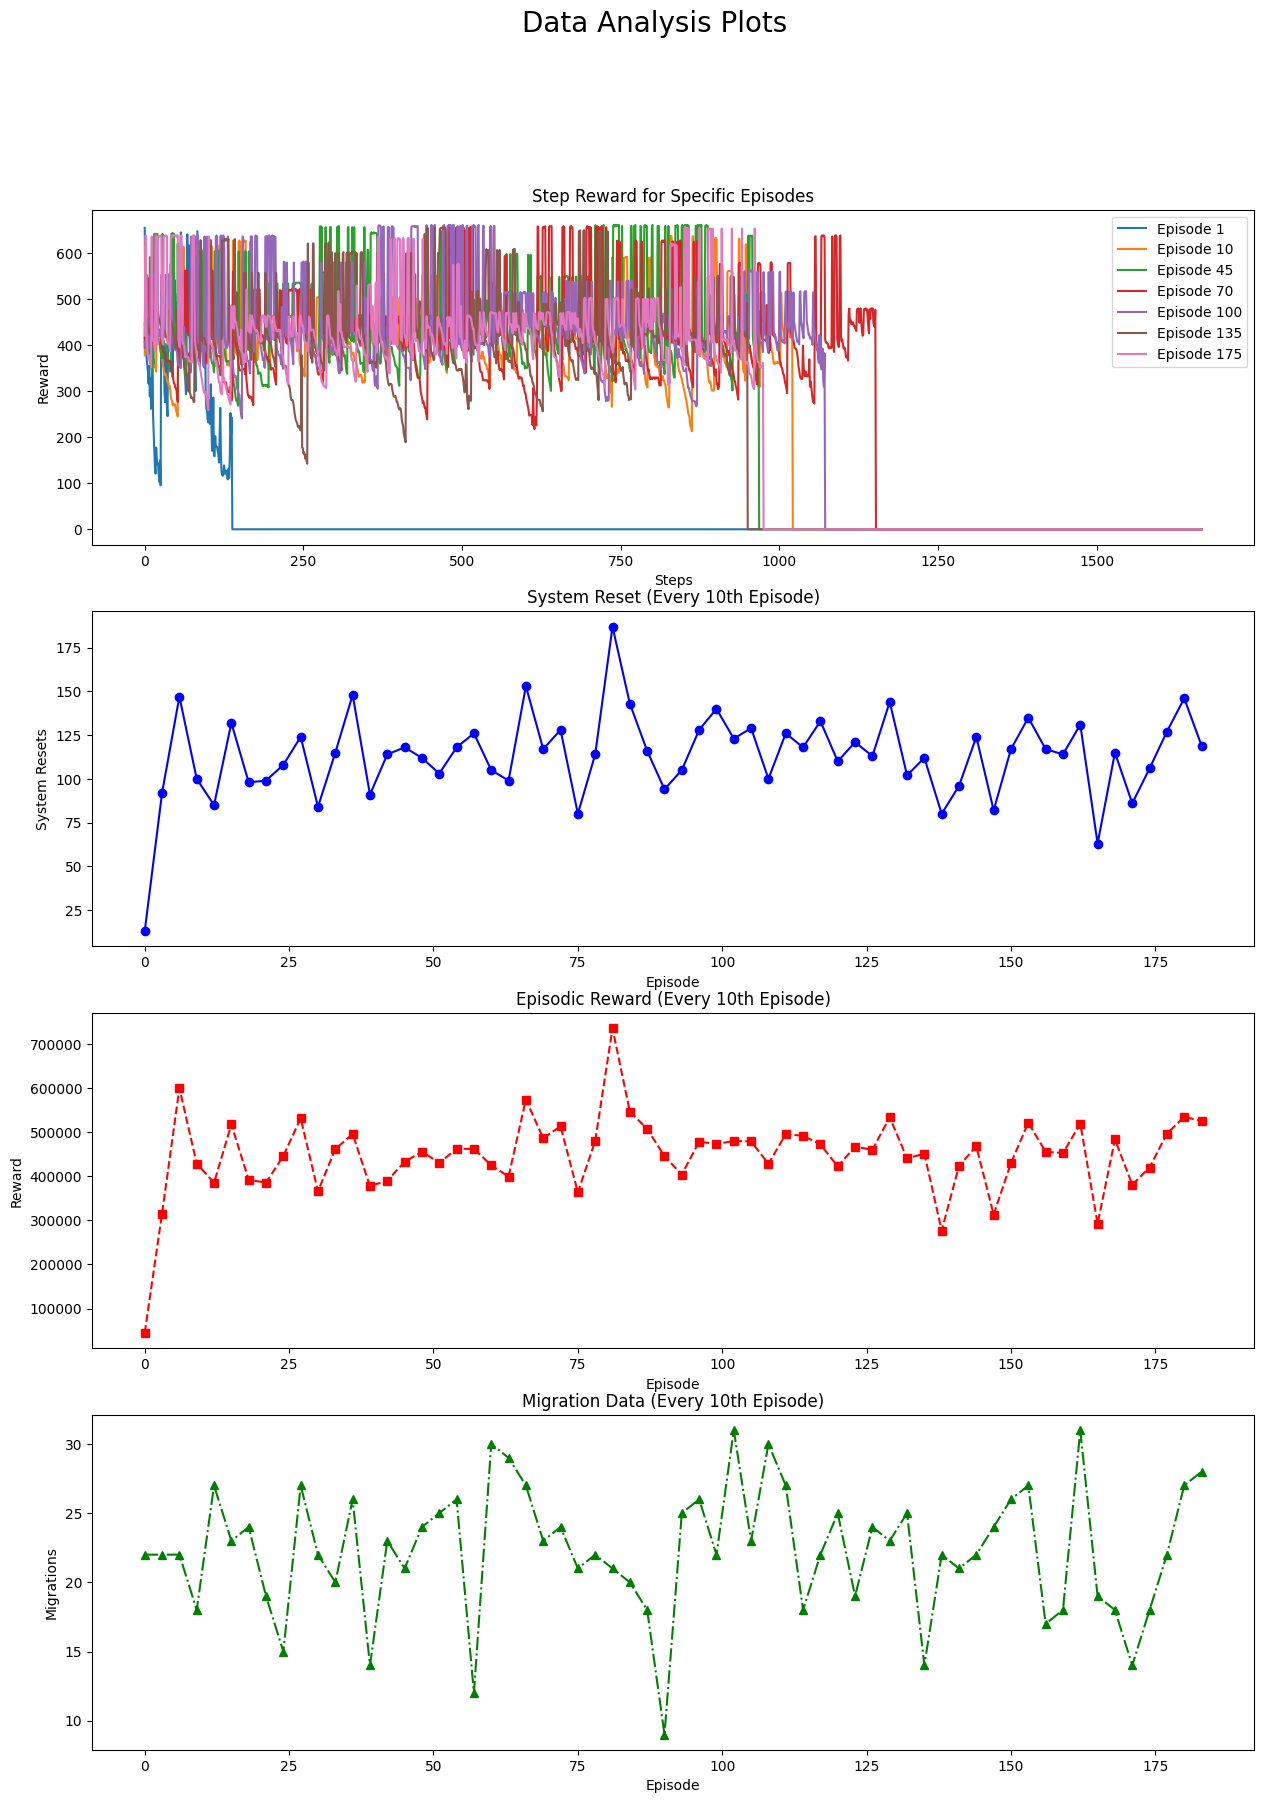

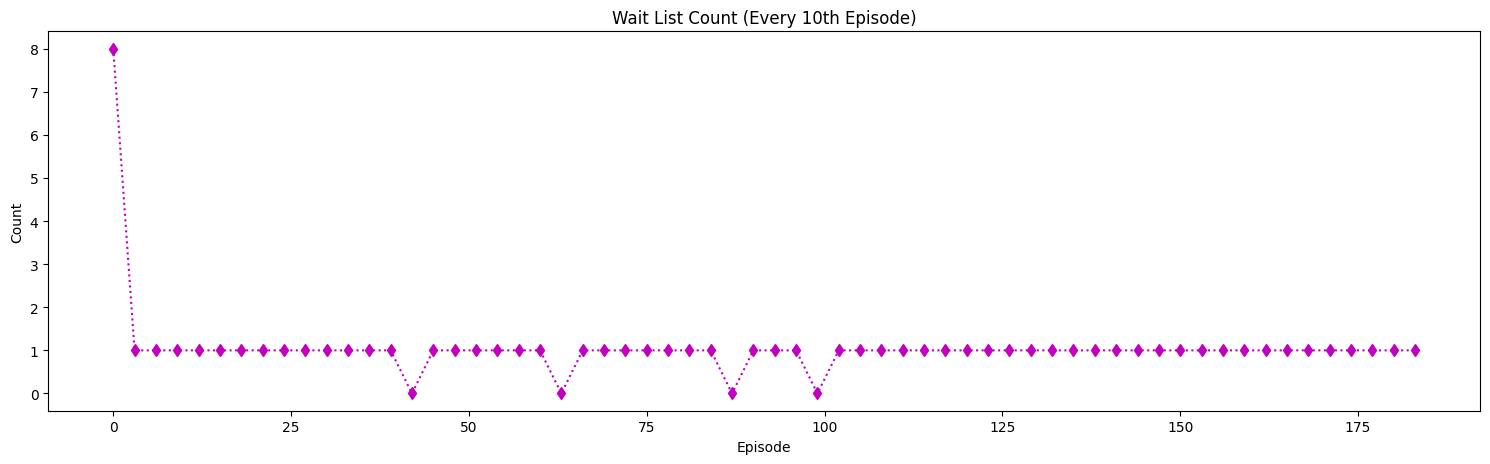

In [ ]:
# Indices of the specific episodes to plot for step_reward
episodes_to_plot = [0, 9, 44, 69, 99, 134, 174]

# Subsample the other lists to every 10th episode
subsample_indices = np.arange(0, len(system_reset_lst_np), 3)
system_reset_lst_subsampled = system_reset_lst_np[subsample_indices]
episodic_reward_subsampled = episodic_reward_np[subsample_indices]
migration_data_subsampled = migration_data_np[subsample_indices]
wait_list_count_subsampled = wait_list_count_np[subsample_indices]

# Create a figure and subplots
fig, axes = plt.subplots(4, 1, figsize=(15, 20))
fig.suptitle('Data Analysis Plots', fontsize=20)

# Plot step_reward_np for the specific episodes
for i, episode in enumerate(episodes_to_plot):
    axes[0].plot(step_reward_np[episode], label=f'Episode {episode + 1}')
axes[0].set_title('Step Reward for Specific Episodes')
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('Reward')
axes[0].legend()

# Plot system_reset_lst_np as a line plot for every 10th episode
axes[1].plot(subsample_indices, system_reset_lst_subsampled, marker='o', linestyle='-', color='b')
axes[1].set_title('System Reset (Every 10th Episode)')
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('System Resets')

# Plot episodic_reward_np as a line plot for every 10th episode
axes[2].plot(subsample_indices, episodic_reward_subsampled, marker='s', linestyle='--', color='r')
axes[2].set_title('Episodic Reward (Every 10th Episode)')
axes[2].set_xlabel('Episode')
axes[2].set_ylabel('Reward')

# Plot migration_data_np as a line plot for every 10th episode
axes[3].plot(subsample_indices, migration_data_subsampled, marker='^', linestyle='-.', color='g')
axes[3].set_title('Migration Data (Every 10th Episode)')
axes[3].set_xlabel('Episode')
axes[3].set_ylabel('Migrations')

# Plot wait_list_count_np as a line plot for every 10th episode in a new figure
fig2, ax2 = plt.subplots(figsize=(15, 5))
ax2.plot(subsample_indices, wait_list_count_subsampled, marker='d', linestyle=':', color='m')
ax2.set_title('Wait List Count (Every 10th Episode)')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Count')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plots
plt.show()

#### 2. Simple DQN Agent with Dense Network Policy


In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, lr=0.001, gamma=0.99, epsilon=1.0,
                 epsilon_decay=0.995, epsilon_min=0.01, batch_size=128):

        self.state_dim = state_size
        self.action_dim = action_size
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.memory = []
        self.batch_size = batch_size
        self.model = self.build_model()
        self.history = []

    def build_model(self):
        model = tf.keras.Sequential([
            Input(shape=(self.state_dim,)),
            Dense(1024, activation="relu"),
            Dense(1024, activation="relu"),
            BatchNormalization(),
            Dense(512, activation="relu", kernel_regularizer=l2(0.01)),
            Dense(512, activation="relu"),
            BatchNormalization(),
            Dense(256, activation="relu"),
            Dense(256, activation="relu"),
            BatchNormalization(),
            Dense(128, activation="relu"),
            Dense(128, activation="relu"),
            BatchNormalization(),
            Dense(64, activation="relu"),
            Dense(64, activation="relu"),
            Dense(32, activation="relu"),
            Dense(16, activation="relu"),
            Dense(8, activation="relu"),
            Dense(self.action_dim, activation='linear')
        ])

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.lr), loss='mse', metrics=["mae", "mse"])
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_dim)
        else:
            state = np.array(state).reshape((1, -1))  # Reshape to include batch dimension
            actn = np.argmax(self.model.predict(state, verbose=0)[0])
            return actn

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = np.array(state).reshape((1, -1))  # Reshape to include batch dimension
            next_state = np.array(next_state).reshape((1, -1))  # Reshape to include batch dimension

            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            history = self.model.fit(state, target_f, epochs=1, verbose=0)
            self.history += [history.history]

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


In [ ]:
# Create the DQN agent
agent = DQNAgent(state_size = 9, action_size = 9)

In [ ]:
# Send the outputs to the output.txt
file_out = open('dqn_output.txt', 'w')

In [ ]:
# Setup the layers, management node and the scheduler
cloud_layer = Layer('cloud_layer', num_nodes = 7, resources_per_node = 20,
                    network_latency_range = [1, 5], failure_rate = 0.2,
                    level = 3)

fog_layer = Layer('fog_layer', num_nodes = 12, resources_per_node = 15,
                  network_latency_range = [1, 5], failure_rate = 0.3,
                  level = 2)

edge_layer = Layer('edge_layer', num_nodes = 25, resources_per_node = 10,
                   network_latency_range = [1, 5], failure_rate = 0.5,
                   level = 1)

# Create the management node and scheduler
management_node = ManagementNode(cloud_layer, fog_layer, edge_layer, None)
scheduler = TaskScheduler(management_node, batch_size = 512)
scheduler.ppo_agent = agent
management_node.scheduler = scheduler

# Create the task generator
generator = TaskGenerator()

In [ ]:
def save_and_download_results(model_name, step_reward, system_reset_lst, episodic_reward, migration_data, wait_list_count):
    # Determine the maximum length
    max_length = max(len(item) for item in step_reward)

    # Pad sequences with zeros
    padded_step_reward = [item + [0] * (max_length - len(item)) for item in step_reward]

    # Convert to NumPy array
    step_reward_np = np.array(padded_step_reward)

    # Convert lists to NumPy arrays
    # step_reward_np = np.array(np.array(step_reward))
    system_reset_lst_np = np.array(system_reset_lst)
    episodic_reward_np = np.array(episodic_reward)
    migration_data_np = np.array(migration_data)
    wait_list_count_np = np.array(wait_list_count)

    # Specify the file names
    step_reward_file = f"{model_name}_step_reward.npy"
    system_reset_lst_file = f"{model_name}_system_reset_lst.npy"
    episodic_reward_file = f"{model_name}_episodic_reward.npy"
    migration_data_file = f"{model_name}_migration_data.npy"
    wait_list_count_file = f"{model_name}_wait_list_count.npy"

    # Save the arrays as .npy files
    np.save(step_reward_file, step_reward_np)
    np.save(system_reset_lst_file, system_reset_lst_np)
    np.save(episodic_reward_file, episodic_reward_np)
    np.save(migration_data_file, migration_data_np)
    np.save(wait_list_count_file, wait_list_count_np)

    print("Data saved as NumPy files")

    # Download the files
    files.download(step_reward_file)
    files.download(system_reset_lst_file)
    files.download(episodic_reward_file)
    files.download(migration_data_file)
    files.download(wait_list_count_file)
    files.download(f"/content/{model_name}_output.txt")

In [ ]:
def run_simulation(model_name, management_node, scheduler, generator):

  # Initialise dictionaries and lists for storing episodic / action - step information
  # i.e. information of the system and simulation after each step undertaken
  step_reward = []   # action - step rewards
  system_reset_lst = []  # count of times the system has been reset
  episodic_reward = []   # accumulated reward for each episode
  migration_data = []  # migrations performed in overall simulation, for each episode
  wait_list_count = []  # max count of tasks at an instance per episode

  # For each episode, random batches of tasks will be created
  # This will be run for 200 episodes
  num_episodes = 200
  for episode in range(num_episodes):
    print("-"*30)
    print(f"[INFO] Episode {episode + 1} started")
    print("-"*30)
    total_ep_reward = 0
    total_migrations = 0
    total_wait_list = 0
    total_system_resets = 0

    num_batches = 1  # The simulations will be held for 1 to 5 batches of 16 tasks randomnly
    ep_step_reward = []

    for batch in range(num_batches):
      # Generate a batch of tasks
      batch_tasks = generator.batch_task_generate(batch_size = 16)
      finish_batch = False  # flag for batch task completion
      scheduler.total_tasks = 16  # total tasks in the batch

      # Schedule each task using the scheduler
      while not all(x.is_completed for x in batch_tasks):
        waitlist_ct = len(management_node.wait_list)

        management_node.wait_list = list(set([task for task in management_node.wait_list if not task.is_completed]))
        tasks = list(set([task for task in batch_tasks if not task.is_completed] + management_node.wait_list))

        # Till all tasks are finished, we will keep on running
        # And done parameter is not returned as True
        for task in tasks:
          action, reward, done = scheduler.schedule_task(task)

          # Increment the analysis parameters
          if action==8: total_system_resets += 1
          total_ep_reward += reward
          ep_step_reward.append(reward)
          total_wait_list = max(total_wait_list, max(waitlist_ct, len(management_node.wait_list)))

          if done:
            break

      for task in batch_tasks:
        total_migrations += task.migrations

      print("-"*30)
      print("-"*30)
      print(f"[INFO] All batch tasks finished.")
      print("-"*30)
      summary = management_node.system_summary()
      print(f"[INFO] Aggregate Layer data:")
      # Print each layer's data
      for layer in summary['layer_data']:
          print(f"Layer Name: {layer['layer_name']}")
          print(f"  Number of Nodes: {layer['num_nodes']}")
          print(f"  Total Resources: {layer['total_resources']}")
          print(f"  Available Resources: {layer['available_resources']}")
          print(f"  Tasks Allocated: {layer['tasks_allocated']}")
          print('-'*30)
      print(f"[INFO] Migrate Lock Status: {summary['migrate_lock']}")
      print('-'*30)
      print(f"[INFO] Tasks Alloted: {summary['tasks_alloted']}")
      print('-'*30)
      print(f"[INFO] Tasks completed: {summary['tasks_completed']}")
      print('-'*30)
      print(f"[INFO] Tasks running currently: {summary['tasks_running']}")
      print('-'*30)
      print(f"[INFO] Tasks in waitlist: {summary['task_in_waitlist']}")
      print('-'*30)
      print(f"[INFO] Total migrations till now: {summary['total_migrations']}")
      print('-'*30)
      if num_batches > 1:
        print(f"[INFO] Proceeding to next batch.")
      print('-'*30)
      print('-'*30)

    # Add the analysis parameters to the lists
    step_reward.append(ep_step_reward)
    episodic_reward.append(total_ep_reward)
    migration_data.append(total_migrations)
    wait_list_count.append(total_wait_list)
    system_reset_lst.append(total_system_resets)
    print("-"*30)
    print(f"[INFO] Episode {episode + 1} completed")
    print("-"*30)

  save_and_download_results(model_name, step_reward, system_reset_lst, episodic_reward, migration_data, wait_list_count)

  return step_reward, system_reset_lst, episodic_reward, migration_data, wait_list_count

In [ ]:
step_reward, system_reset_lst, episodic_reward, migration_data, wait_list_count = run_simulation()

Streaming output truncated to the last 5000 lines.
------------------------------
------------------------------
------------------------------
[INFO] Episode 146 completed
------------------------------
------------------------------
[INFO] Episode 147 started
------------------------------
---------------
[INFO] Task 2349 has been completed successfully
---------------
---------------
[INFO] Task 2341 has been completed successfully
---------------
---------------
[INFO] Task 2344 has been completed successfully
---------------
---------------
[INFO] Task 2346 has been completed successfully
---------------
---------------
[INFO] Task 2342 has been completed successfully
---------------
---------------
[INFO] Task 2347 has been completed successfully
---------------
---------------
[INFO] Task 2338 has been completed successfully
---------------
---------------
[INFO] Task 2352 has been completed successfully
---------------
---------------
[INFO] Task 2340 has been completed success

In [ ]:
# Determine the maximum length
max_length = max(len(item) for item in step_reward)

# Pad sequences with zeros
padded_step_reward = [item + [0] * (max_length - len(item)) for item in step_reward]

# Convert to NumPy array
step_reward_np = np.array(padded_step_reward)


# Convert lists to NumPy arrays
# step_reward_np = np.array(np.array(step_reward))
system_reset_lst_np = np.array(system_reset_lst)
episodic_reward_np = np.array(episodic_reward)
migration_data_np = np.array(migration_data)
wait_list_count_np = np.array(wait_list_count)

# Specify the file names
step_reward_file = "dqn_step_reward.npy"
system_reset_lst_file = "dqn_system_reset_lst.npy"
episodic_reward_file = "dqn_episodic_reward.npy"
migration_data_file = "dqn_migration_data.npy"
wait_list_count_file = "dqn_wait_list_count.npy"

# Save the arrays as .npy files
np.save(step_reward_file, step_reward_np)
np.save(system_reset_lst_file, system_reset_lst_np)
np.save(episodic_reward_file, episodic_reward_np)
np.save(migration_data_file, migration_data_np)
np.save(wait_list_count_file, wait_list_count_np)

print("Data saved as NumPy files")

Data saved as NumPy files


In [ ]:
from google.colab import files

# Download the files
files.download(step_reward_file)
files.download(system_reset_lst_file)
files.download(episodic_reward_file)
files.download(migration_data_file)
files.download(wait_list_count_file)
files.download("/content/dqn_output.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

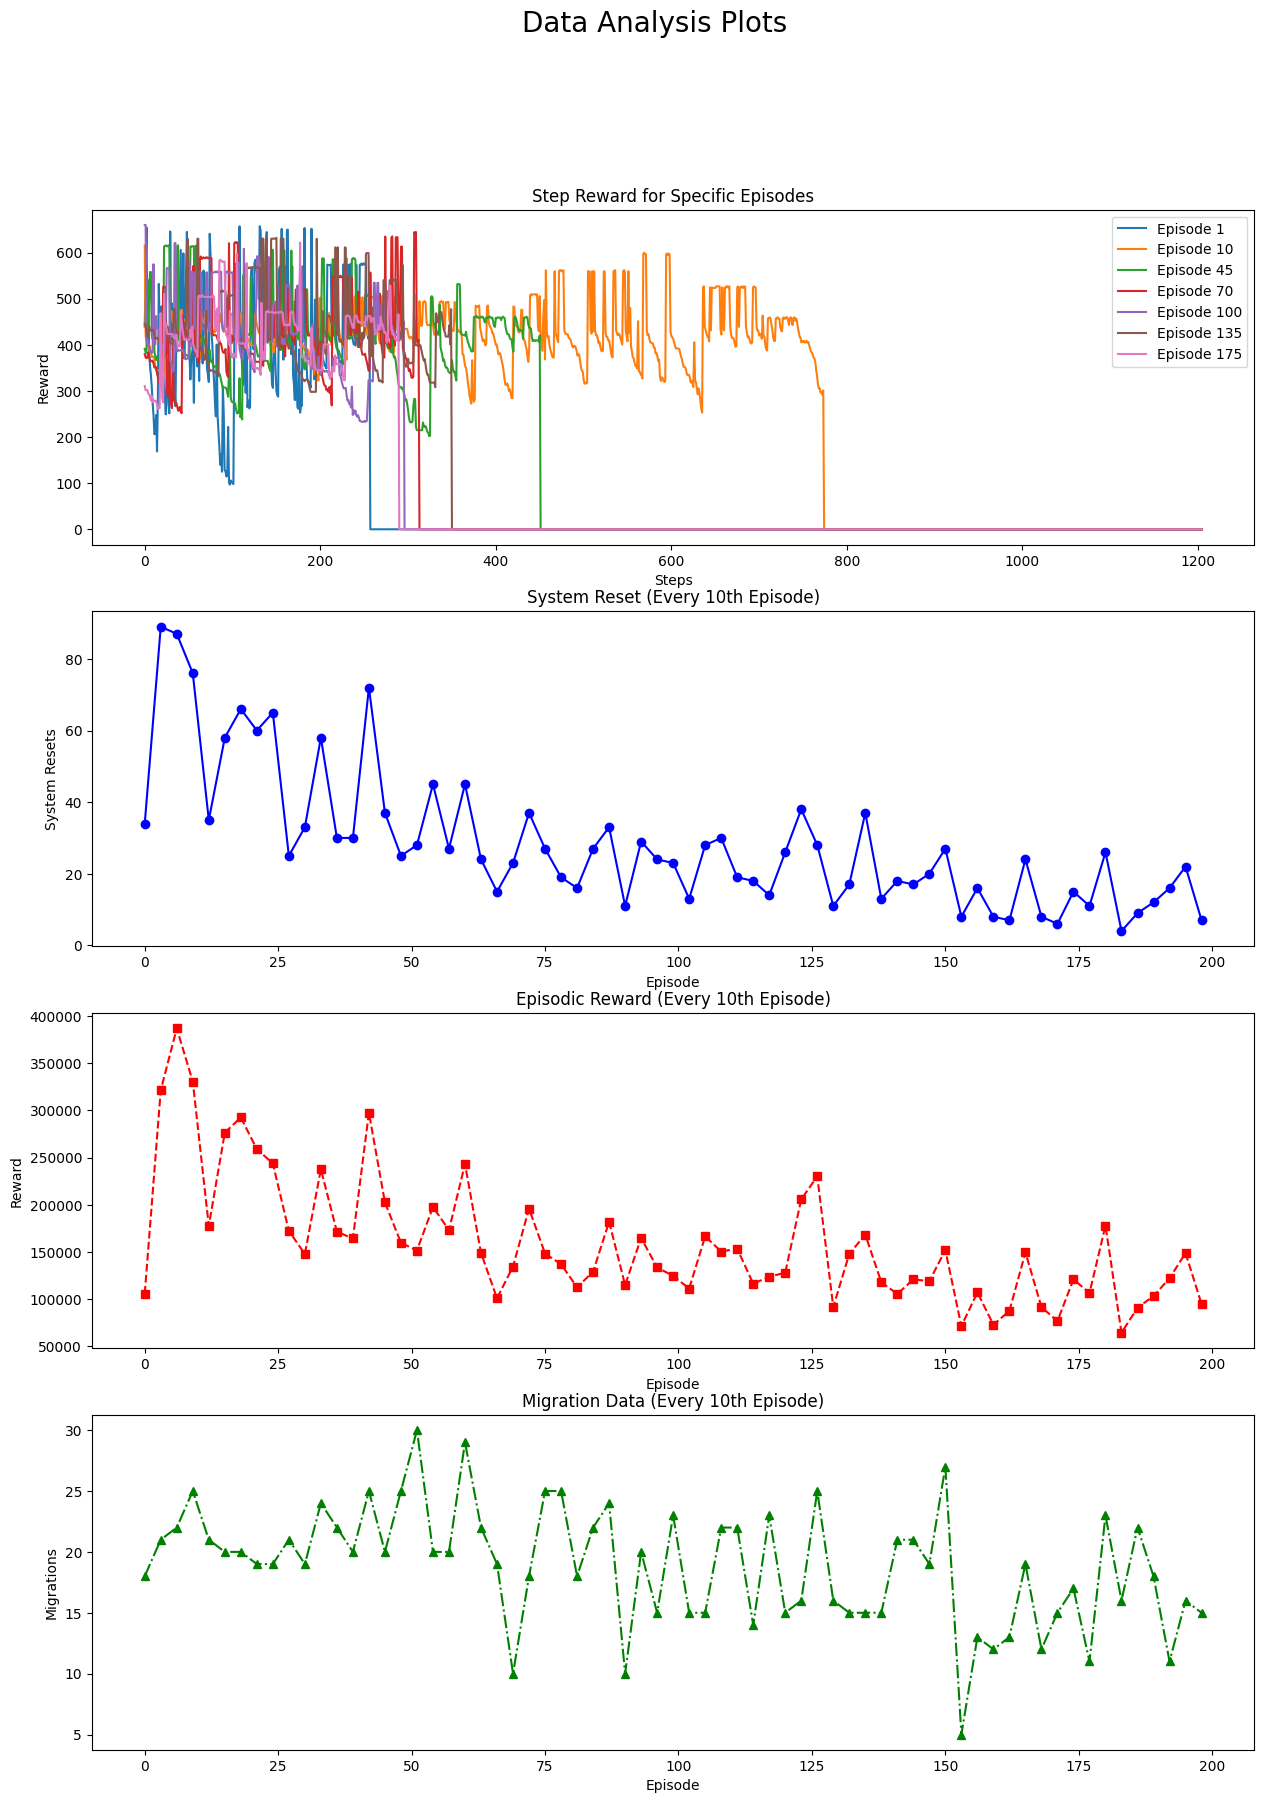

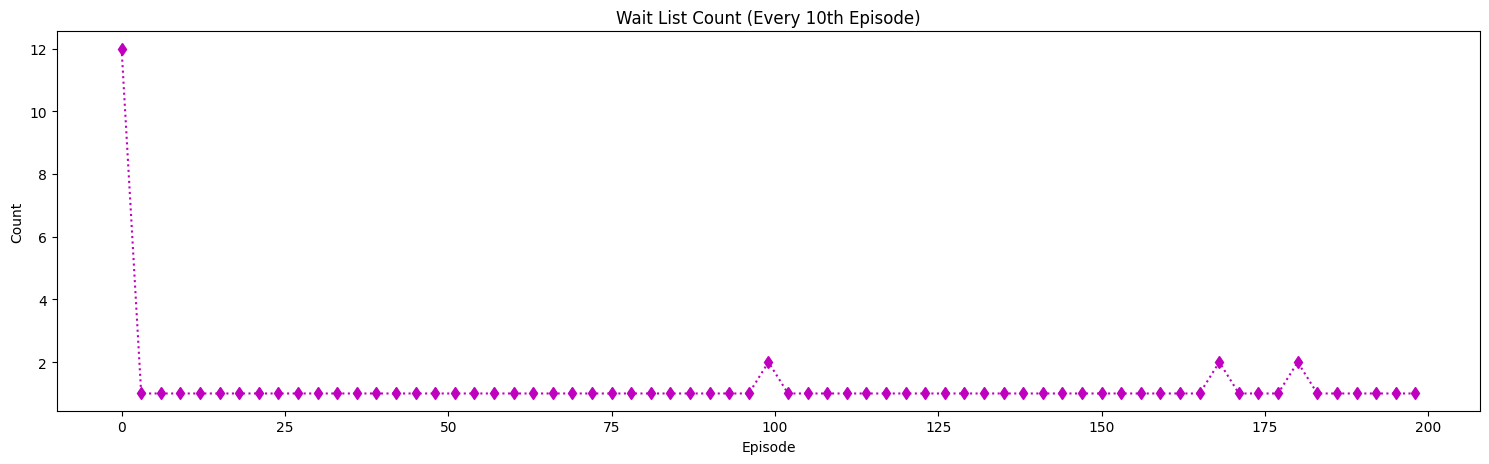

In [ ]:
# Indices of the specific episodes to plot for step_reward
episodes_to_plot = [0, 9, 44, 69, 99, 134, 174]

# Subsample the other lists to every 10th episode
subsample_indices = np.arange(0, len(system_reset_lst_np), 3)
system_reset_lst_subsampled = system_reset_lst_np[subsample_indices]
episodic_reward_subsampled = episodic_reward_np[subsample_indices]
migration_data_subsampled = migration_data_np[subsample_indices]
wait_list_count_subsampled = wait_list_count_np[subsample_indices]

# Create a figure and subplots
fig, axes = plt.subplots(4, 1, figsize=(15, 20))
fig.suptitle('Data Analysis Plots', fontsize=20)

# Plot step_reward_np for the specific episodes
for i, episode in enumerate(episodes_to_plot):
    axes[0].plot(step_reward_np[episode], label=f'Episode {episode + 1}')
axes[0].set_title('Step Reward for Specific Episodes')
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('Reward')
axes[0].legend()

# Plot system_reset_lst_np as a line plot for every 10th episode
axes[1].plot(subsample_indices, system_reset_lst_subsampled, marker='o', linestyle='-', color='b')
axes[1].set_title('System Reset (Every 10th Episode)')
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('System Resets')

# Plot episodic_reward_np as a line plot for every 10th episode
axes[2].plot(subsample_indices, episodic_reward_subsampled, marker='s', linestyle='--', color='r')
axes[2].set_title('Episodic Reward (Every 10th Episode)')
axes[2].set_xlabel('Episode')
axes[2].set_ylabel('Reward')

# Plot migration_data_np as a line plot for every 10th episode
axes[3].plot(subsample_indices, migration_data_subsampled, marker='^', linestyle='-.', color='g')
axes[3].set_title('Migration Data (Every 10th Episode)')
axes[3].set_xlabel('Episode')
axes[3].set_ylabel('Migrations')

# Plot wait_list_count_np as a line plot for every 10th episode in a new figure
fig2, ax2 = plt.subplots(figsize=(15, 5))
ax2.plot(subsample_indices, wait_list_count_subsampled, marker='d', linestyle=':', color='m')
ax2.set_title('Wait List Count (Every 10th Episode)')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Count')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plots
plt.show()

#### 3. Double DQN Framework

In [ ]:
class DDQNAgent:
    def __init__(self, state_size, action_size, lr=0.001, gamma=0.99, epsilon=1.0,
                 epsilon_decay=0.995, epsilon_min=0.01, batch_size=128, target_update=128):
        self.state_dim = state_size
        self.action_dim = action_size
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.memory = []
        self.batch_size = batch_size
        self.target_update = target_update
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.update_target_model()
        self.history = []
        self.train_step = 0  # Track the number of training steps

    def build_model(self):
        model = Sequential([
            Input(shape=(self.state_dim,)),
            Dense(512, activation="relu", kernel_regularizer=l2(0.01)),
            Dense(512, activation="relu"),
            BatchNormalization(),
            Dense(256, activation="relu"),
            Dense(256, activation="relu"),
            BatchNormalization(),
            Dense(64, activation="relu"),
            Dense(64, activation="relu"),
            Dense(32, activation="relu"),
            Dense(16, activation="relu"),
            Dense(8, activation="relu"),
            Dense(self.action_dim, activation='linear')
        ])

        model.compile(optimizer=Adam(learning_rate=self.lr), loss='mse', metrics=["mae", "mse"])
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def act(self, state):
        state = np.array(state).reshape((1, -1))  # Ensure the state has the batch dimension
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_dim)
        else:
            actn = np.argmax(self.model.predict(state, verbose=0)[0])
            return actn

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = np.array(state).reshape((1, -1))  # Reshape to include batch dimension
            next_state = np.array(next_state).reshape((1, -1))  # Reshape to include batch dimension

            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            history = self.model.fit(state, target_f, epochs=1, verbose=0)
            self.history += [history.history]

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)
        self.target_model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)
        self.target_model.save_weights(name)


In [ ]:
# Create the DQN agent
agent = DDQNAgent(state_size = 9, action_size = 9)

In [ ]:
# Send the outputs to the output.txt
file_out = open('ddqn_output.txt', 'w')

In [ ]:
# Setup the layers, management node and the scheduler
cloud_layer = Layer('cloud_layer', num_nodes = 7, resources_per_node = 20,
                    network_latency_range = [1, 5], failure_rate = 0.2,
                    level = 3)

fog_layer = Layer('fog_layer', num_nodes = 12, resources_per_node = 15,
                  network_latency_range = [1, 5], failure_rate = 0.3,
                  level = 2)

edge_layer = Layer('edge_layer', num_nodes = 25, resources_per_node = 10,
                   network_latency_range = [1, 5], failure_rate = 0.5,
                   level = 1)

# Create the management node and scheduler
management_node = ManagementNode(cloud_layer, fog_layer, edge_layer, None)
scheduler = TaskScheduler(management_node, batch_size = 1024)
scheduler.ppo_agent = agent
management_node.scheduler = scheduler

# Create the task generator
generator = TaskGenerator()

In [ ]:
step_reward, system_reset_lst, episodic_reward, migration_data, wait_list_count = run_simulation(model_name = 'ddqn',
                                                                                                 management_node = management_node,
                                                                                                 scheduler = scheduler,
                                                                                                 generator = generator)

Streaming output truncated to the last 5000 lines.
[INFO] Training the DQN agent
--------------------
---------------
[INFO] Task 2010 has been completed successfully
---------------
---------------
[INFO] Task 2006 has been completed successfully
---------------
------------------------------
------------------------------
[INFO] All batch tasks finished.
------------------------------
[INFO] Aggregate Layer data:
Layer Name: cloud_layer
  Number of Nodes: 7
  Total Resources: 140
  Available Resources: 108
  Tasks Allocated: 1846
------------------------------
Layer Name: fog_layer
  Number of Nodes: 12
  Total Resources: 180
  Available Resources: 165
  Tasks Allocated: 1856
------------------------------
Layer Name: edge_layer
  Number of Nodes: 25
  Total Resources: 250
  Available Resources: 250
  Tasks Allocated: 1869
------------------------------
[INFO] Migrate Lock Status: 0
------------------------------
[INFO] Tasks Alloted: [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 17, 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-32-467443480ebb>", line 1, in <cell line: 1>
    step_reward, system_reset_lst, episodic_reward, migration_data, wait_list_count = run_simulation(model_name = 'ddqn',
  File "<ipython-input-27-0b7a05bd6a89>", line 42, in run_simulation
    action, reward, done = scheduler.schedule_task(task)
  File "<ipython-input-23-1fe2895897f6>", line 69, in schedule_task
    action = self.ppo_agent.act(current_state)
  File "<ipython-input-28-83c5b97db569>", line 48, in act
    actn = np.argmax(self.model.predict(state, verbose=0)[0])
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 446, in predict


TypeError: object of type 'NoneType' has no len()

In [ ]:
# Indices of the specific episodes to plot for step_reward
episodes_to_plot = [0, 9, 44, 69, 99, 134, 174]

# Subsample the other lists to every 10th episode
subsample_indices = np.arange(0, len(system_reset_lst_np), 3)
system_reset_lst_subsampled = system_reset_lst_np[subsample_indices]
episodic_reward_subsampled = episodic_reward_np[subsample_indices]
migration_data_subsampled = migration_data_np[subsample_indices]
wait_list_count_subsampled = wait_list_count_np[subsample_indices]

# Create a figure and subplots
fig, axes = plt.subplots(4, 1, figsize=(15, 20))
fig.suptitle('Data Analysis Plots', fontsize=20)

# Plot step_reward_np for the specific episodes
for i, episode in enumerate(episodes_to_plot):
    axes[0].plot(step_reward_np[episode], label=f'Episode {episode + 1}')
axes[0].set_title('Step Reward for Specific Episodes')
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('Reward')
axes[0].legend()

# Plot system_reset_lst_np as a line plot for every 10th episode
axes[1].plot(subsample_indices, system_reset_lst_subsampled, marker='o', linestyle='-', color='b')
axes[1].set_title('System Reset (Every 10th Episode)')
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('System Resets')

# Plot episodic_reward_np as a line plot for every 10th episode
axes[2].plot(subsample_indices, episodic_reward_subsampled, marker='s', linestyle='--', color='r')
axes[2].set_title('Episodic Reward (Every 10th Episode)')
axes[2].set_xlabel('Episode')
axes[2].set_ylabel('Reward')

# Plot migration_data_np as a line plot for every 10th episode
axes[3].plot(subsample_indices, migration_data_subsampled, marker='^', linestyle='-.', color='g')
axes[3].set_title('Migration Data (Every 10th Episode)')
axes[3].set_xlabel('Episode')
axes[3].set_ylabel('Migrations')

# Plot wait_list_count_np as a line plot for every 10th episode in a new figure
fig2, ax2 = plt.subplots(figsize=(15, 5))
ax2.plot(subsample_indices, wait_list_count_subsampled, marker='d', linestyle=':', color='m')
ax2.set_title('Wait List Count (Every 10th Episode)')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Count')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plots
plt.show()

#### 4. Dueling DQN


In [ ]:
class DuelingDQNAgent:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99, epsilon=1.0,
                 epsilon_decay=0.995, epsilon_min=0.01, batch_size=128):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.memory = []
        self.batch_size = batch_size
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.update_target_model()
        self.history = []

    def build_model(self):
        inputs = Input(shape=(self.state_dim,))
        x = Dense(128, activation='relu')(inputs)
        x = Dense(128, activation='relu')(x)

        # Dueling Architecture
        value_fc = Dense(128, activation='relu')(x)
        value = Dense(1, activation='linear')(value_fc)

        advantage_fc = Dense(128, activation='relu')(x)
        advantage = Dense(self.action_dim, activation='linear')(advantage_fc)

        # Combine value and advantage streams
        q_values = Lambda(lambda a: a[0] + (a[1] - tf.reduce_mean(a[1], axis=1, keepdims=True)),
                          output_shape=(self.action_dim,))([value, advantage])

        model = Model(inputs=inputs, outputs=q_values)
        model.compile(optimizer=Adam(learning_rate=self.lr), loss='mse')
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def act(self, state):
        state = np.array(state).reshape(1, -1)  # Reshape to (1, state_dim)
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_dim)
        else:
            return np.argmax(self.model.predict(state, verbose=0)[0])


    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = np.array(state).reshape(1, -1)
            next_state = np.array(next_state).reshape(1, -1)

            target = reward
            if not done:
                t = self.model.predict(next_state, verbose=0)[0]
                t_next = self.target_model.predict(next_state, verbose=0)[0]
                target = reward + self.gamma * t_next[np.argmax(t)]

            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        self.memory = []

    def load(self, name):
        self.model.load_weights(name)
        self.target_model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)
        self.target_model.save_weights(name)

In [ ]:
# Create the DQN agent
agent = DDQNAgent(state_size = 9, action_size = 9)

In [ ]:
# Send the outputs to the output.txt
file_out = open('duel_dqn_output.txt', 'w')

In [ ]:
# Setup the layers, management node and the scheduler
cloud_layer = Layer('cloud_layer', num_nodes = 7, resources_per_node = 20,
                    network_latency_range = [1, 5], failure_rate = 0.2,
                    level = 3)

fog_layer = Layer('fog_layer', num_nodes = 12, resources_per_node = 15,
                  network_latency_range = [1, 5], failure_rate = 0.3,
                  level = 2)

edge_layer = Layer('edge_layer', num_nodes = 25, resources_per_node = 10,
                   network_latency_range = [1, 5], failure_rate = 0.5,
                   level = 1)

# Create the management node and scheduler
management_node = ManagementNode(cloud_layer, fog_layer, edge_layer, None)
scheduler = TaskScheduler(management_node, batch_size = 512)
scheduler.ppo_agent = agent
management_node.scheduler = scheduler

# Create the task generator
generator = TaskGenerator()

In [ ]:
step_reward, system_reset_lst, episodic_reward, migration_data, wait_list_count = run_simulation(management_node = management_node, scheduler = scheduler, generator = generator)

In [ ]:
# Determine the maximum length
max_length = max(len(item) for item in step_reward)

# Pad sequences with zeros
padded_step_reward = [item + [0] * (max_length - len(item)) for item in step_reward]

# Convert to NumPy array
step_reward_np = np.array(padded_step_reward)


# Convert lists to NumPy arrays
# step_reward_np = np.array(np.array(step_reward))
system_reset_lst_np = np.array(system_reset_lst)
episodic_reward_np = np.array(episodic_reward)
migration_data_np = np.array(migration_data)
wait_list_count_np = np.array(wait_list_count)

# Specify the file names
step_reward_file = "duel_dqn_step_reward.npy"
system_reset_lst_file = "duel_dqn_system_reset_lst.npy"
episodic_reward_file = "duel_dqn_episodic_reward.npy"
migration_data_file = "duel_dqn_migration_data.npy"
wait_list_count_file = "duel_dqn_wait_list_count.npy"

# Save the arrays as .npy files
np.save(step_reward_file, step_reward_np)
np.save(system_reset_lst_file, system_reset_lst_np)
np.save(episodic_reward_file, episodic_reward_np)
np.save(migration_data_file, migration_data_np)
np.save(wait_list_count_file, wait_list_count_np)

print("Data saved as NumPy files")

In [ ]:
from google.colab import files

# Download the files
files.download(step_reward_file)
files.download(system_reset_lst_file)
files.download(episodic_reward_file)
files.download(migration_data_file)
files.download(wait_list_count_file)
files.download("/content/duel_dqn_output.txt")

In [ ]:
# Indices of the specific episodes to plot for step_reward
episodes_to_plot = [0, 9, 44, 69, 99, 134, 174]

# Subsample the other lists to every 10th episode
subsample_indices = np.arange(0, len(system_reset_lst_np), 3)
system_reset_lst_subsampled = system_reset_lst_np[subsample_indices]
episodic_reward_subsampled = episodic_reward_np[subsample_indices]
migration_data_subsampled = migration_data_np[subsample_indices]
wait_list_count_subsampled = wait_list_count_np[subsample_indices]

# Create a figure and subplots
fig, axes = plt.subplots(4, 1, figsize=(15, 20))
fig.suptitle('Data Analysis Plots', fontsize=20)

# Plot step_reward_np for the specific episodes
for i, episode in enumerate(episodes_to_plot):
    axes[0].plot(step_reward_np[episode], label=f'Episode {episode + 1}')
axes[0].set_title('Step Reward for Specific Episodes')
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('Reward')
axes[0].legend()

# Plot system_reset_lst_np as a line plot for every 10th episode
axes[1].plot(subsample_indices, system_reset_lst_subsampled, marker='o', linestyle='-', color='b')
axes[1].set_title('System Reset (Every 10th Episode)')
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('System Resets')

# Plot episodic_reward_np as a line plot for every 10th episode
axes[2].plot(subsample_indices, episodic_reward_subsampled, marker='s', linestyle='--', color='r')
axes[2].set_title('Episodic Reward (Every 10th Episode)')
axes[2].set_xlabel('Episode')
axes[2].set_ylabel('Reward')

# Plot migration_data_np as a line plot for every 10th episode
axes[3].plot(subsample_indices, migration_data_subsampled, marker='^', linestyle='-.', color='g')
axes[3].set_title('Migration Data (Every 10th Episode)')
axes[3].set_xlabel('Episode')
axes[3].set_ylabel('Migrations')

# Plot wait_list_count_np as a line plot for every 10th episode in a new figure
fig2, ax2 = plt.subplots(figsize=(15, 5))
ax2.plot(subsample_indices, wait_list_count_subsampled, marker='d', linestyle=':', color='m')
ax2.set_title('Wait List Count (Every 10th Episode)')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Count')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plots
plt.show()

### Comparative results of the Agents

In [ ]:
# Proposed Method result data
step_reward_file = "step_reward.npy"
system_reset_lst_file = "system_reset_lst.npy"
episodic_reward_file = "episodic_reward.npy"
migration_data_file = "migration_data.npy"
wait_list_count_file = "wait_list_count.npy"

prop_step_reward = np.load(step_reward_file)
prop_system_reset_lst = np.load(system_reset_lst_file)
prop_episodic_reward = np.load(episodic_reward_file)
prop_migration_data = np.load(migration_data_file)
prop_wait_list_count = np.load(wait_list_count_file)

In [ ]:
len(prop_step_reward), len(prop_system_reset_lst), len(prop_episodic_reward), len(prop_migration_data), len(prop_wait_list_count)

(184, 184, 184, 184, 184)

In [ ]:
# DQN method result data
step_reward_file = "dqn_step_reward.npy"
system_reset_lst_file = "dqn_system_reset_lst.npy"
episodic_reward_file = "dqn_episodic_reward.npy"
migration_data_file = "dqn_migration_data.npy"
wait_list_count_file = "dqn_wait_list_count.npy"

dqn_step_reward = np.load(step_reward_file)
dqn_system_reset_lst = np.load(system_reset_lst_file)
dqn_episodic_reward = np.load(episodic_reward_file)
dqn_migration_data = np.load(migration_data_file)
dqn_wait_list_count = np.load(wait_list_count_file)

In [ ]:
len(dqn_step_reward), len(dqn_system_reset_lst), len(dqn_episodic_reward), len(dqn_migration_data), len(dqn_wait_list_count)

(200, 200, 200, 200, 200)

In [ ]:
# Double DQN method result data
step_reward_file = "ddqn_step_reward.npy"
system_reset_lst_file = "ddqn_system_reset_lst.npy"
episodic_reward_file = "ddqn_episodic_reward.npy"
migration_data_file = "ddqn_migration_data.npy"
wait_list_count_file = "ddqn_wait_list_count.npy"

ddqn_step_reward = np.load(step_reward_file)
ddqn_system_reset_lst = np.load(system_reset_lst_file)
ddqn_episodic_reward = np.load(episodic_reward_file)
ddqn_migration_data = np.load(migration_data_file)
ddqn_wait_list_count = np.load(wait_list_count_file)

In [ ]:
len(ddqn_step_reward), len(ddqn_system_reset_lst), len(ddqn_episodic_reward), len(ddqn_migration_data), len(ddqn_wait_list_count)

(90, 90, 90, 90, 90)

In [ ]:
# Dueling-DQN method result data
step_reward_file = "duel_dqn_step_reward.npy"
system_reset_lst_file = "duel_dqn_system_reset_lst.npy"
episodic_reward_file = "duel_dqn_episodic_reward.npy"
migration_data_file = "duel_dqn_migration_data.npy"
wait_list_count_file = "duel_dqn_wait_list_count.npy"

duel_dqn_step_reward = np.load(step_reward_file)
duel_dqn_system_reset_lst = np.load(system_reset_lst_file)
duel_dqn_episodic_reward = np.load(episodic_reward_file)
duel_dqn_migration_data = np.load(migration_data_file)
duel_dqn_wait_list_count = np.load(wait_list_count_file)

In [ ]:
len(duel_dqn_step_reward), len(duel_dqn_system_reset_lst), len(duel_dqn_episodic_reward), len(duel_dqn_migration_data), len(duel_dqn_wait_list_count)

(50, 50, 50, 50, 50)

#### System reset plot

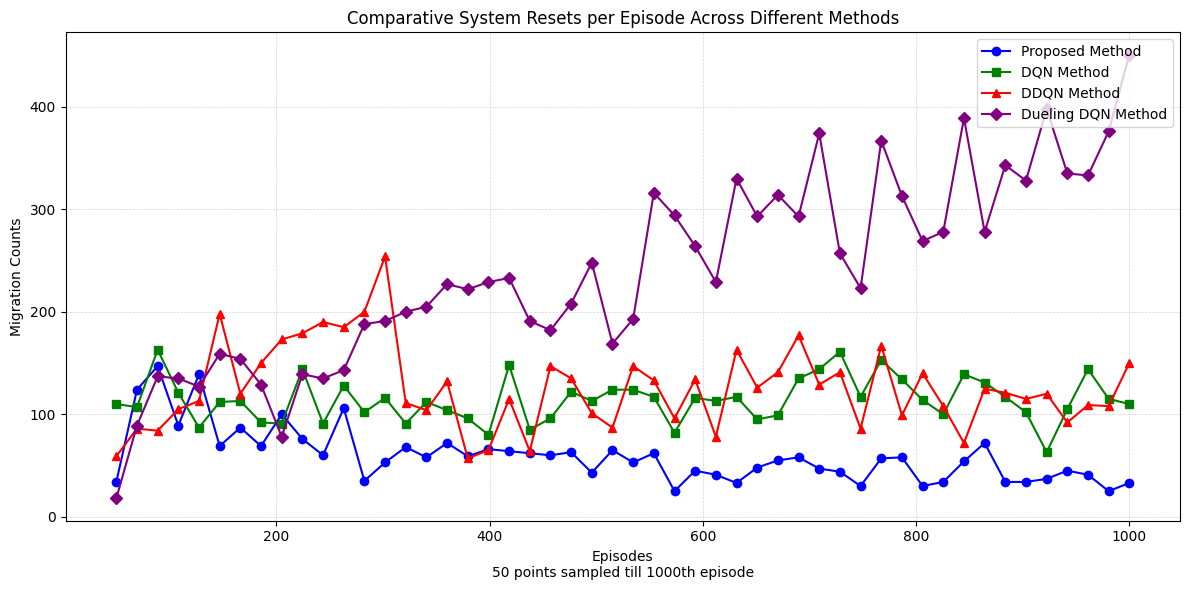

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Determine the minimum size for consistent comparison across episodes
min_size = min(len(prop_system_reset_lst),
               len(dqn_system_reset_lst),
               len(ddqn_system_reset_lst),
               len(duel_dqn_system_reset_lst))

# Truncate each list to the minimum size for a uniform episode count
sl1 = prop_system_reset_lst[120:120+min_size]
sl2 = dqn_system_reset_lst[:min_size]
sl3 = ddqn_system_reset_lst[:min_size]
sl4 = duel_dqn_system_reset_lst[:min_size]

# Create an array for episodes, rescaled to represent multiples of 50 up to 1000
episodes = np.linspace(50, 1000, min_size)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(episodes, sl2, label='Proposed Method', color='blue', linestyle='-', marker='o')
plt.plot(episodes, sl1, label='DQN Method', color='green', linestyle='-', marker='s')
plt.plot(episodes, sl3, label='DDQN Method', color='red', linestyle='-', marker='^')
plt.plot(episodes, sl4, label='Dueling DQN Method', color='purple', linestyle='-', marker='D')


# Add titles and labels
plt.title("Comparative System Resets per Episode Across Different Methods")
plt.xlabel("Episodes\n50 points sampled till 1000th episode")
plt.ylabel("Migration Counts")

# Add grid lines and legend
plt.grid(visible=True, which='both', color='lightgrey', linestyle='--', linewidth=0.5)
plt.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


#### Migration count plot

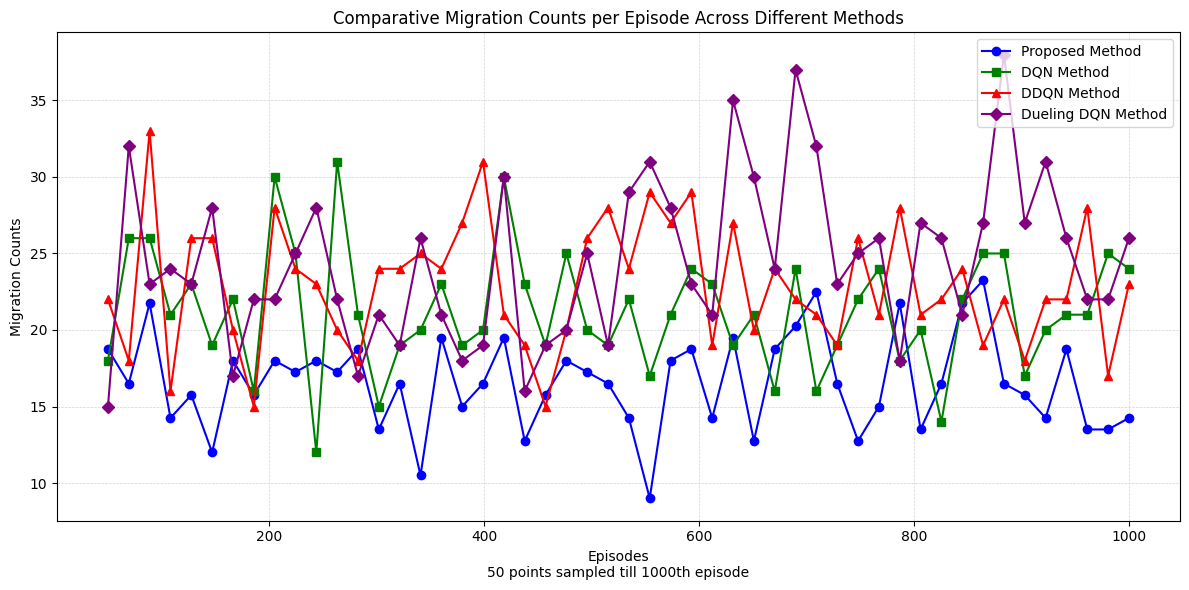

In [ ]:
# Determine the minimum size for consistent comparison across episodes
min_size = min(len(prop_migration_data),
               len(dqn_migration_data),
               len(ddqn_migration_data),
               len(duel_dqn_migration_data))

# Truncate each list to the minimum size for a uniform episode count
sl1 = prop_migration_data[120:120+min_size]
sl2 = dqn_migration_data[:min_size]
sl3 = ddqn_migration_data[:min_size]
sl4 = duel_dqn_migration_data[:min_size]


# Create an array for episodes, rescaled to represent multiples of 50 up to 1000
episodes = np.linspace(50, 1000, min_size)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(episodes, sl1_adjusted, label='Proposed Method', color='blue', linestyle='-', marker='o')
plt.plot(episodes, sl2, label='DQN Method', color='green', linestyle='-', marker='s')
plt.plot(episodes, sl4, label='DDQN Method', color='red', linestyle='-', marker='^')
plt.plot(episodes, sl3, label='Dueling DQN Method', color='purple', linestyle='-', marker='D')

# Add titles and labels
plt.title("Comparative Migration Counts per Episode Across Different Methods")
plt.xlabel("Episodes\n50 points sampled till 1000th episode")
plt.ylabel("Migration Counts")

# Add grid lines and legend
plt.grid(visible=True, which='both', color='lightgrey', linestyle='--', linewidth=0.5)
plt.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

#### Episodic Reward plot

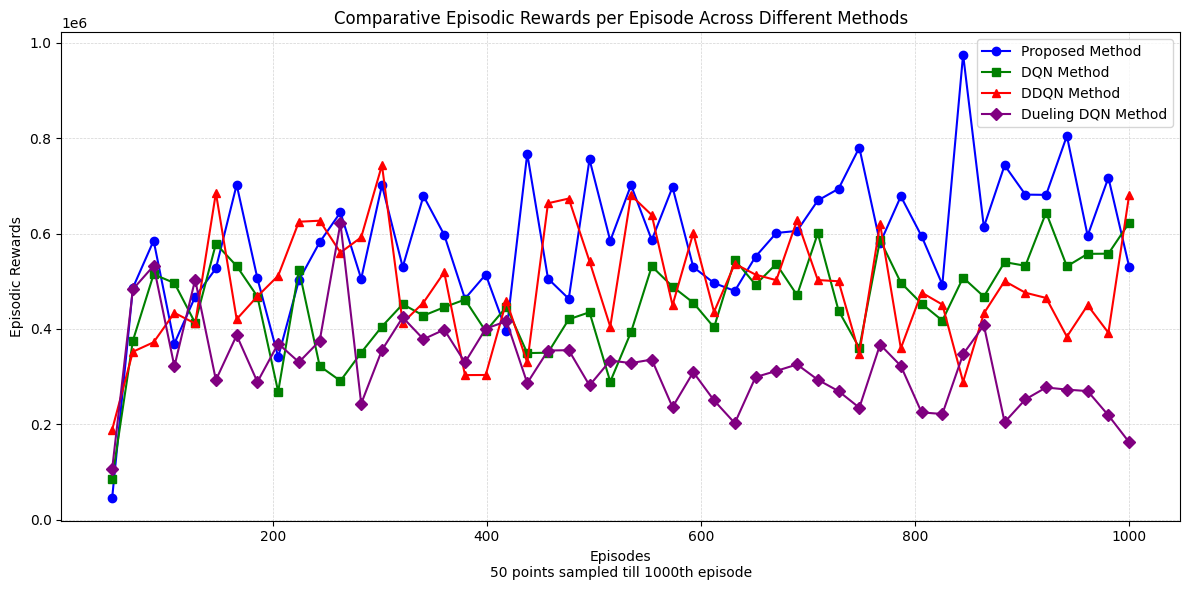

In [ ]:
# Determine the minimum size for consistent comparison across episodes
min_size = min(len(prop_episodic_reward),
               len(dqn_episodic_reward),
               len(ddqn_episodic_reward),
               len(duel_dqn_episodic_reward))

# Truncate each list to the minimum size for a uniform episode count
sl1 = prop_episodic_reward[:min_size]
sl2 = dqn_episodic_reward[:min_size]
sl3 = ddqn_episodic_reward[:min_size]
sl4 = duel_dqn_episodic_reward[:min_size]

# Create an array for episodes
episodes = np.linspace(50, 1000, min_size)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(episodes, sl1, label='Proposed Method', color='blue', linestyle='-', marker='o')
plt.plot(episodes, sl4, label='DQN Method', color='green', linestyle='-', marker='s')
plt.plot(episodes, sl3, label='DDQN Method', color='red', linestyle='-', marker='^')
plt.plot(episodes, sl2, label='Dueling DQN Method', color='purple', linestyle='-', marker='D')

# Add titles and labels
plt.title("Comparative Episodic Rewards per Episode Across Different Methods")
plt.xlabel("Episodes\n50 points sampled till 1000th episode")
plt.ylabel("Episodic Rewards")

# Add grid lines and legend
plt.grid(visible=True, which='both', color='lightgrey', linestyle='--', linewidth=0.5)
plt.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

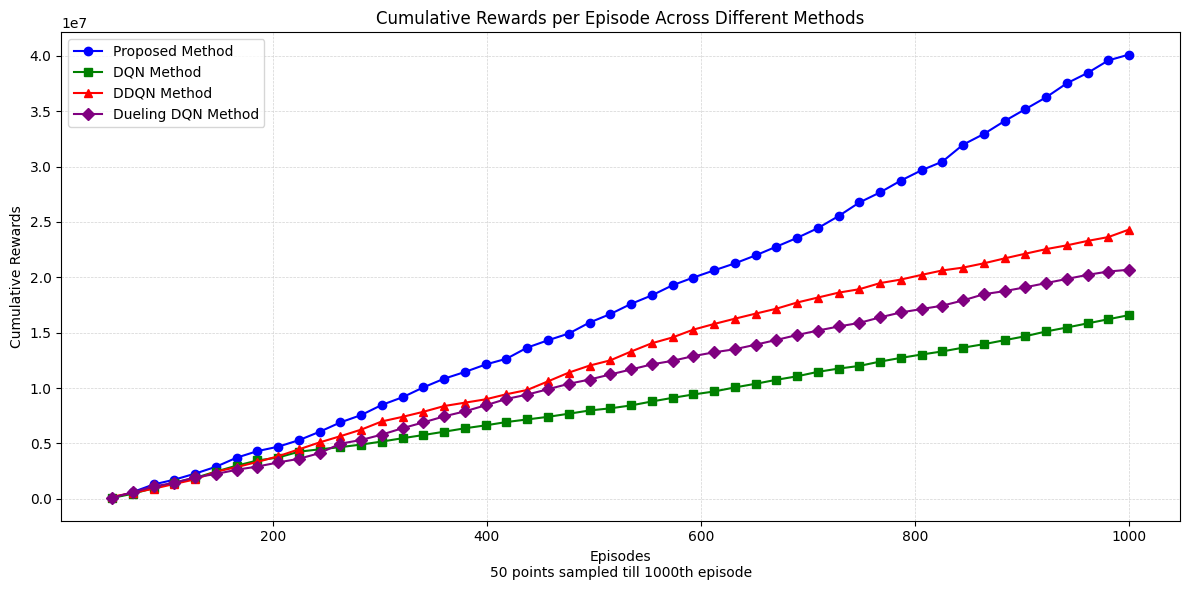

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Determine the minimum size for consistent comparison across episodes
min_size = min(len(prop_episodic_reward),
               len(dqn_episodic_reward),
               len(ddqn_episodic_reward),
               len(duel_dqn_episodic_reward))

# Truncate each list to the minimum size for a uniform episode count
sl1 = prop_episodic_reward[:min_size]
sl2 = dqn_episodic_reward[:min_size]
sl3 = ddqn_episodic_reward[:min_size]
sl4 = duel_dqn_episodic_reward[:min_size]

# Calculate cumulative rewards
cumulative_sl1 = np.cumsum(sl1)
cumulative_sl2 = np.cumsum(sl2)
cumulative_sl3 = np.cumsum(sl3)
cumulative_sl4 = np.cumsum(sl4)

# Create an array for episodes, rescaled to represent multiples of 50 up to 1000
episodes = np.linspace(50, 1000, min_size)

# Create the cumulative plot
plt.figure(figsize=(12, 6))
plt.plot(episodes, cumulative_sl1, label='Proposed Method', color='blue', linestyle='-', marker='o')
plt.plot(episodes, cumulative_sl4, label='DQN Method', color='green', linestyle='-', marker='s')
plt.plot(episodes, cumulative_sl3, label='DDQN Method', color='red', linestyle='-', marker='^')
plt.plot(episodes, cumulative_sl2, label='Dueling DQN Method', color='purple', linestyle='-', marker='D')

# Add titles and labels
plt.title("Cumulative Rewards per Episode Across Different Methods")
plt.xlabel("Episodes\n50 points sampled till 1000th episode")
plt.ylabel("Cumulative Rewards")

# Add grid lines and legend
plt.grid(visible=True, which='both', color='lightgrey', linestyle='--', linewidth=0.5)
plt.legend(loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()